In [1]:
## import the necessary libraries

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import profile_line
import tifffile as tf
from scipy.signal import find_peaks

In [2]:
## define the image and xls paths 
imgfile = 'WT_0.5BSA_03_P2.tif'
xlspos = 'WT_0.5BSA_03_P2_position.xls'
xlsvel = 'velocities.xlsx'

## read in the green fluorescent image and xls file
img = tf.imread(imgfile)[:, 1, :, :]
positions = pd.read_excel(xlspos, header = 1)
velocities = pd.read_excel(xlsvel, header = 1)

In [3]:
## parse the xls file and define constants
sorted_positions = positions.sort_values('TrackID')
sorted_x = sorted_positions.iloc[:, 0]
sorted_y = sorted_positions.iloc[:, 1]
sorted_time = sorted_positions.iloc[:, 6]
sorted_trackids = sorted_positions.iloc[:, 7]
unique_trackids = set(sorted_trackids.values)

## um/pix
pixsc = 0.3230005

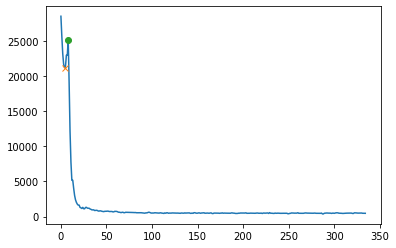

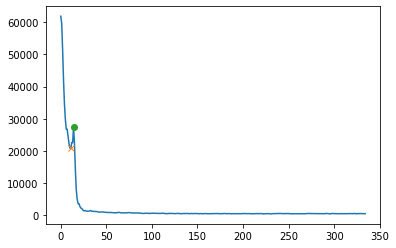

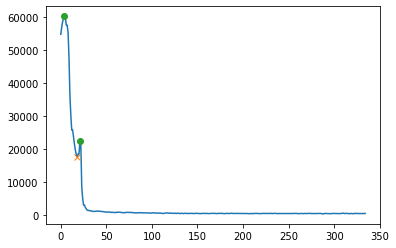

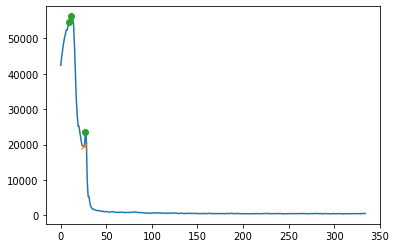

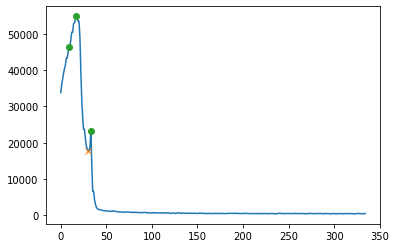

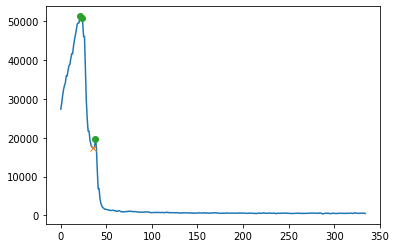

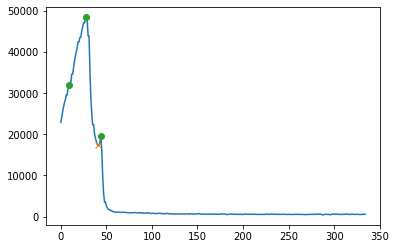

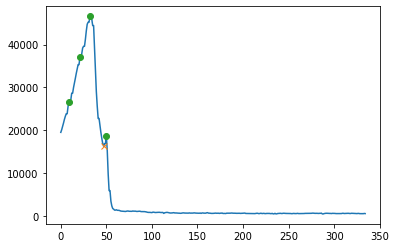

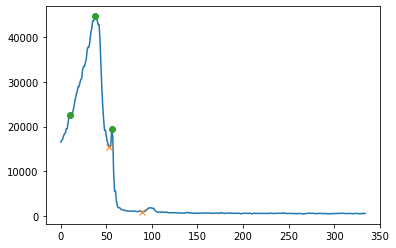

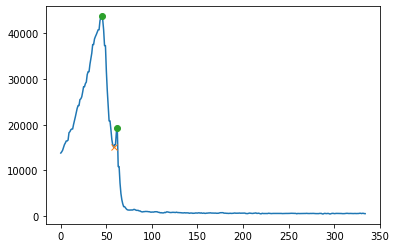

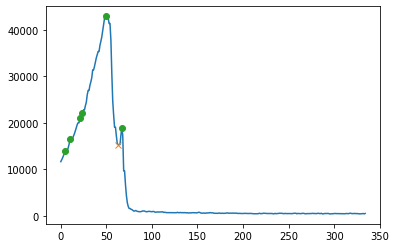

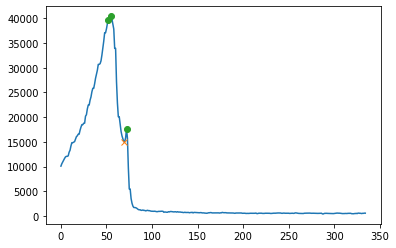

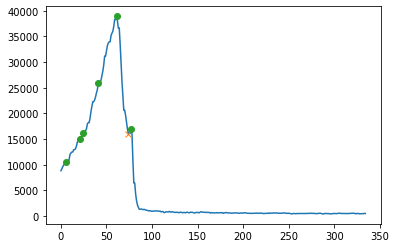

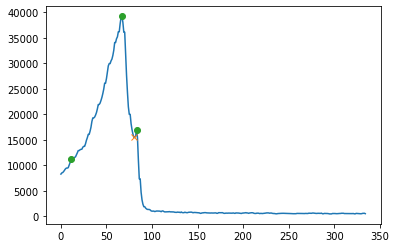

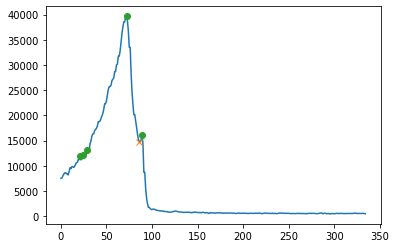

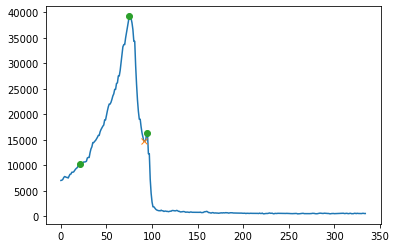

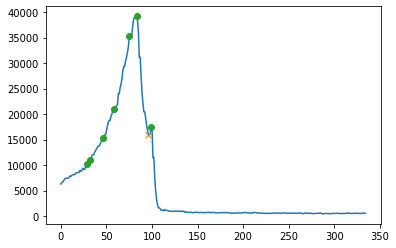

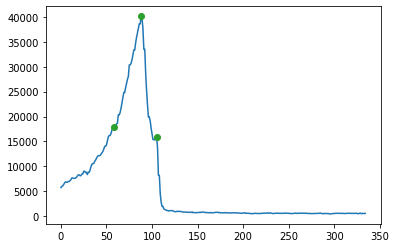

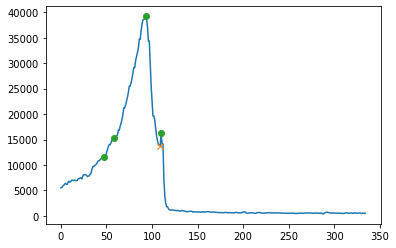

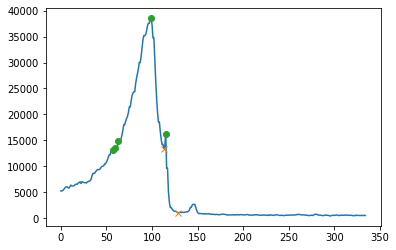

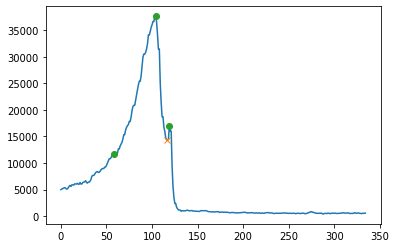

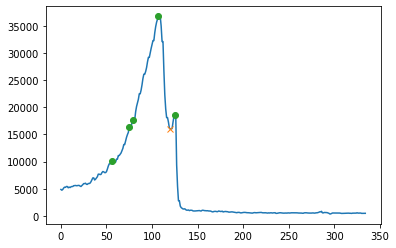

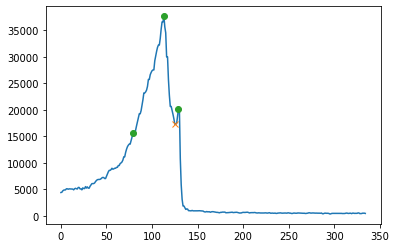

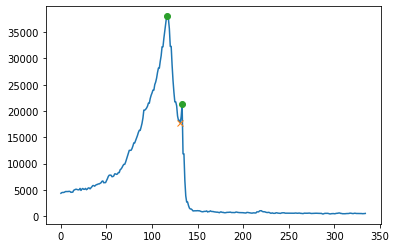

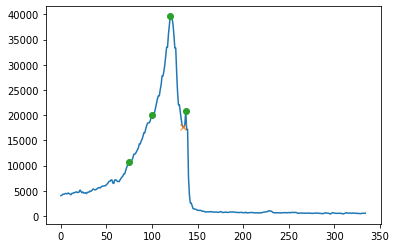

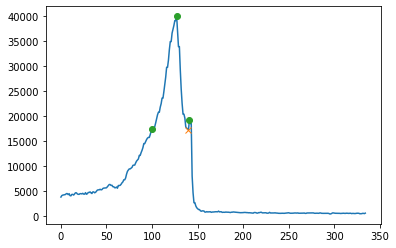

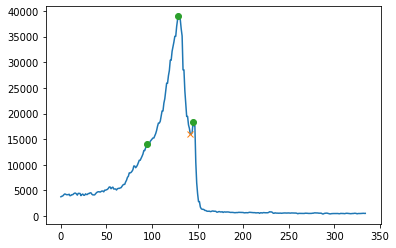

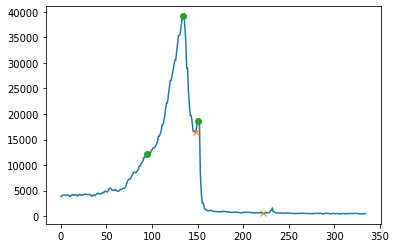

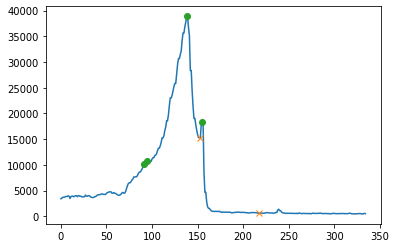

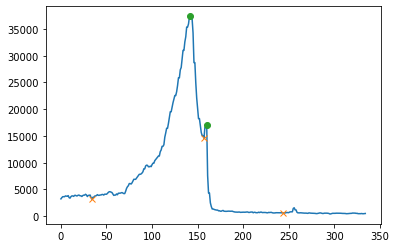

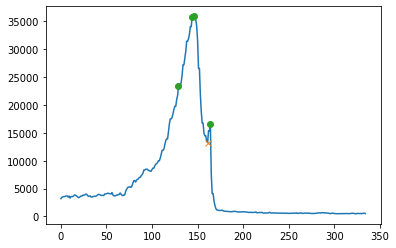

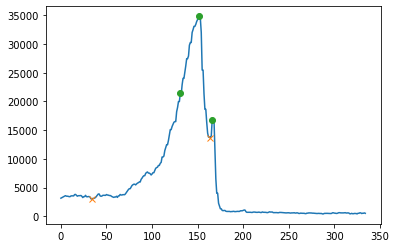

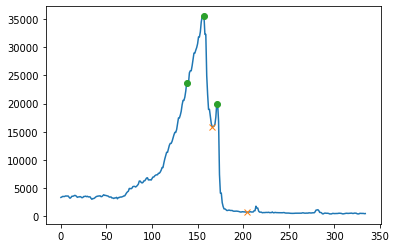

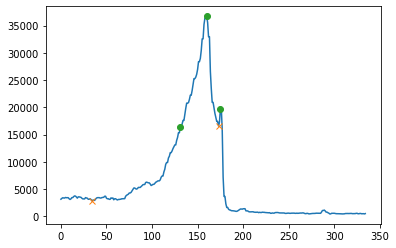

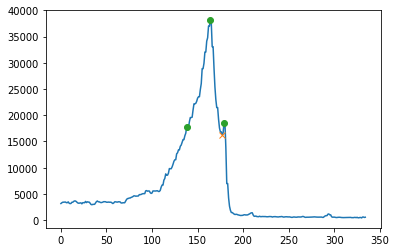

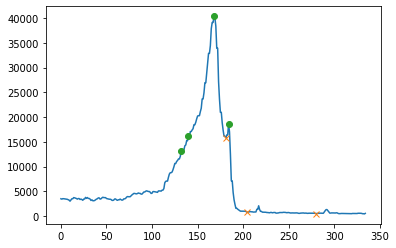

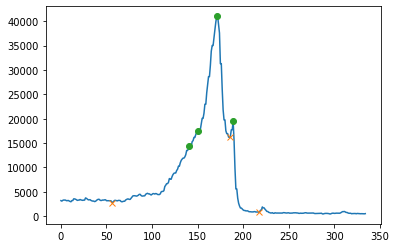

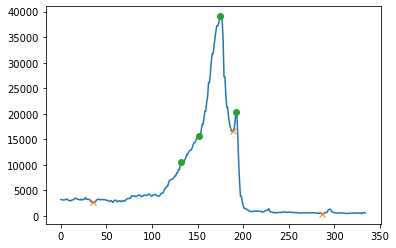

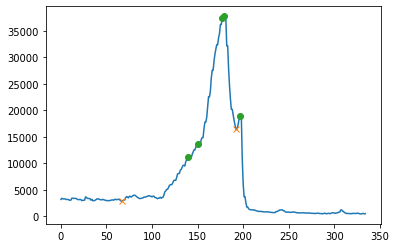

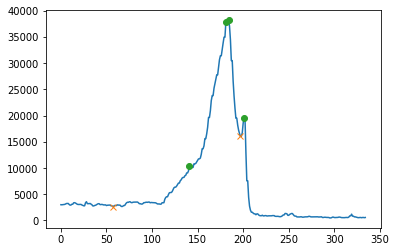

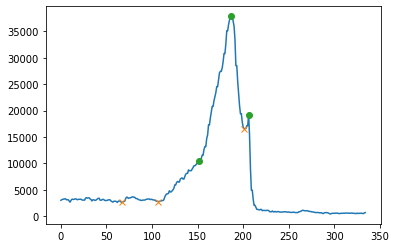

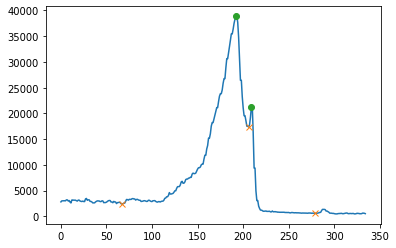

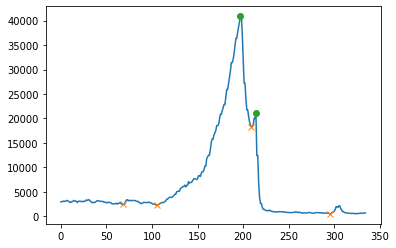

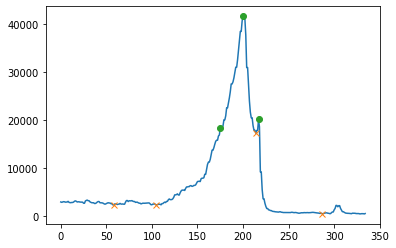

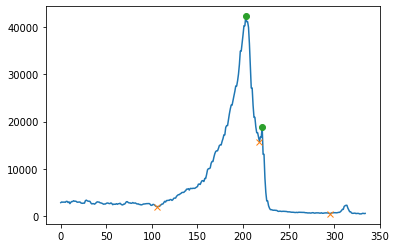

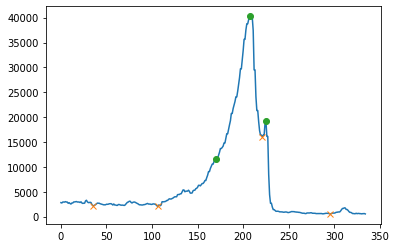

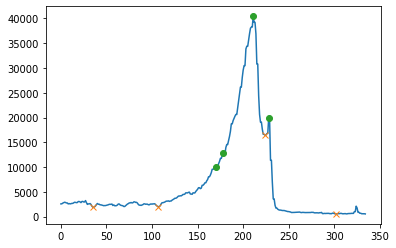

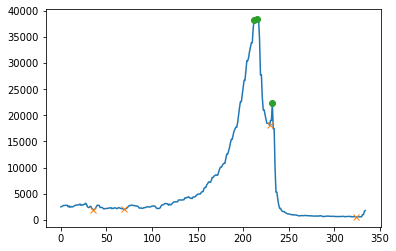

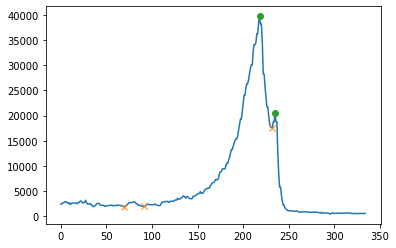

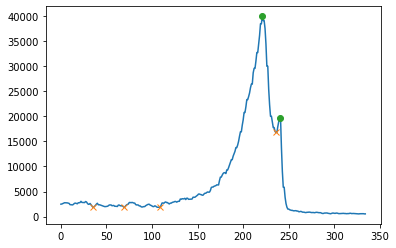

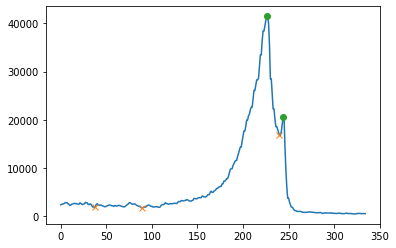

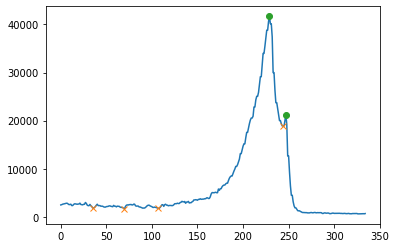

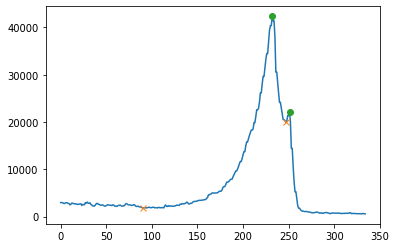

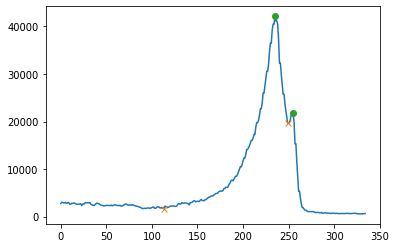

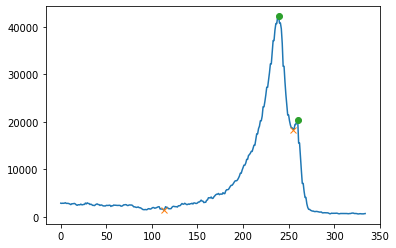

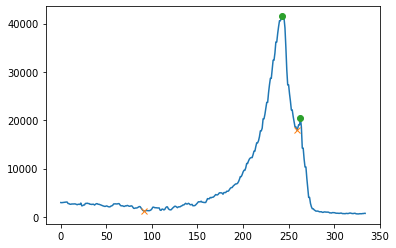

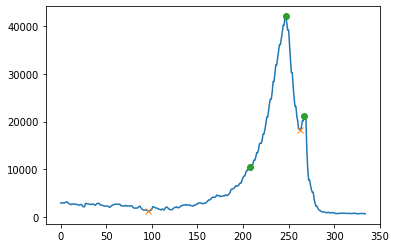

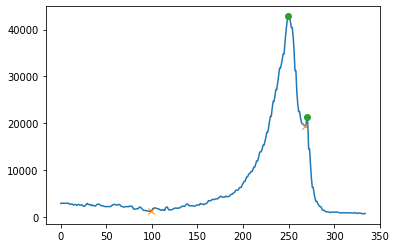

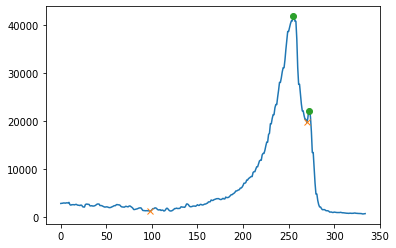

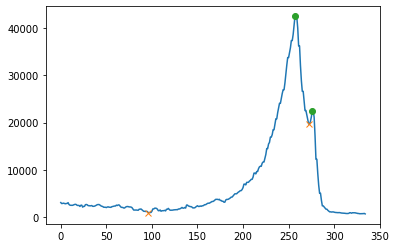

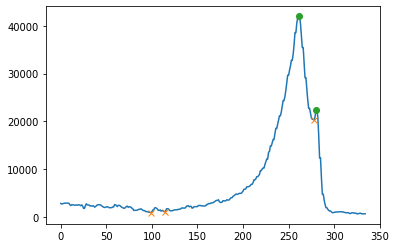

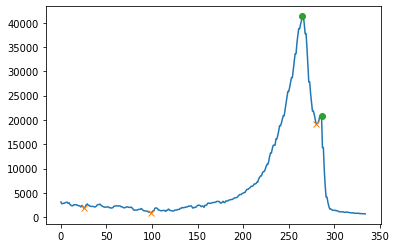

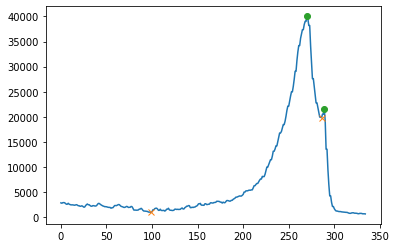

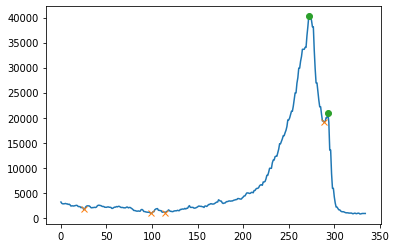

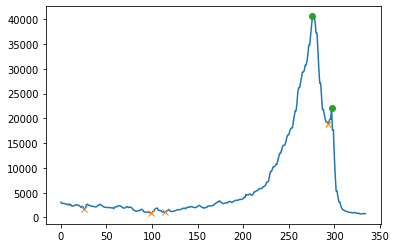

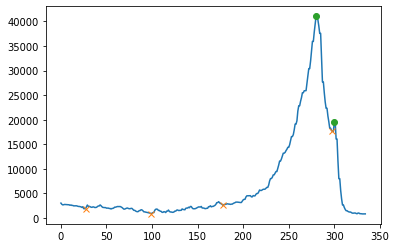

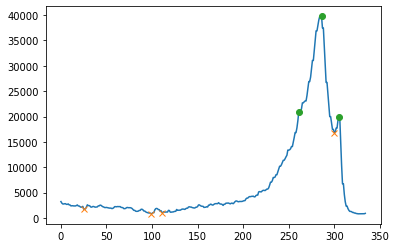

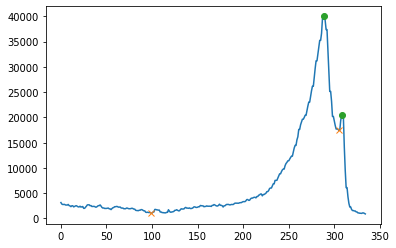

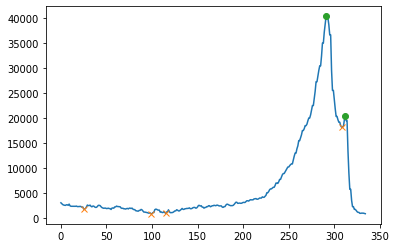

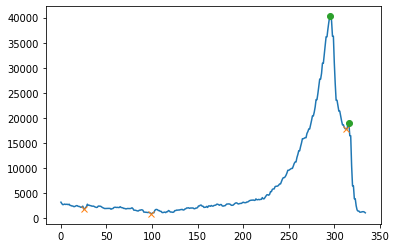

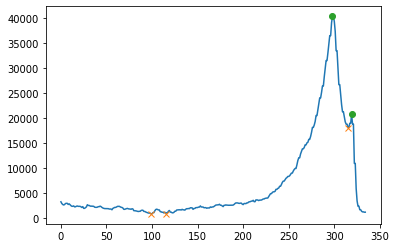

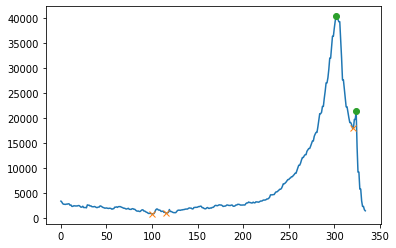

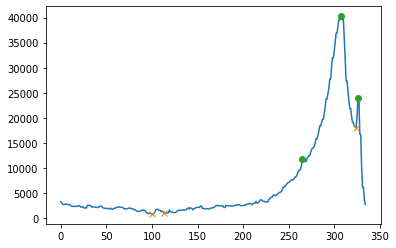

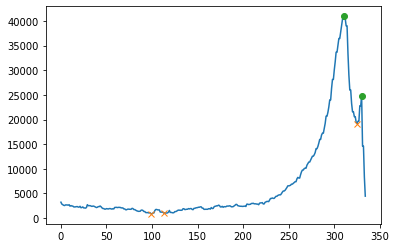

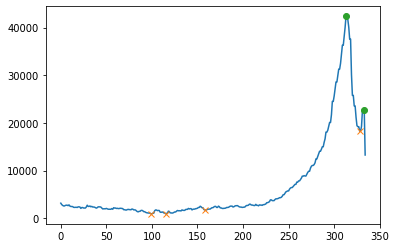

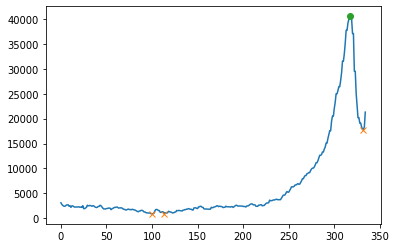

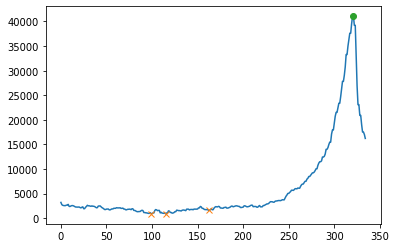

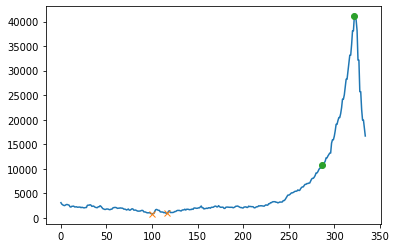

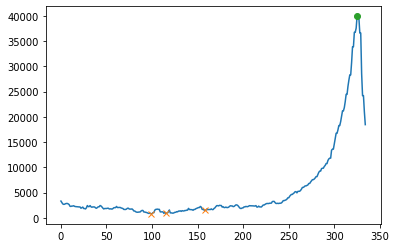

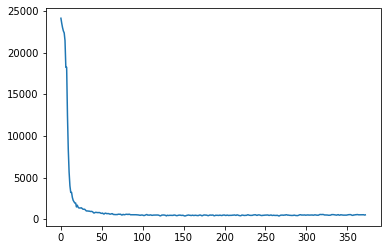

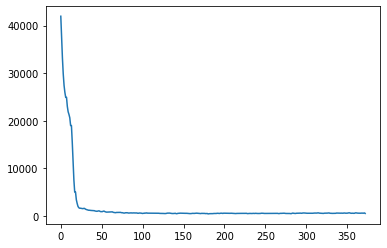

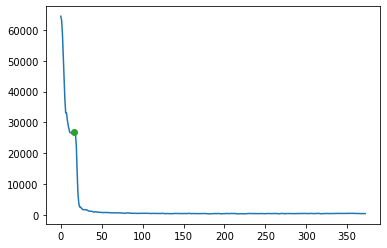

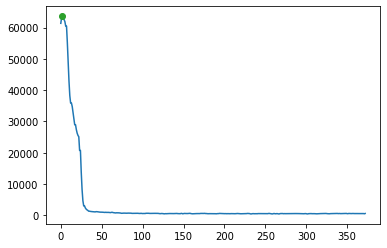

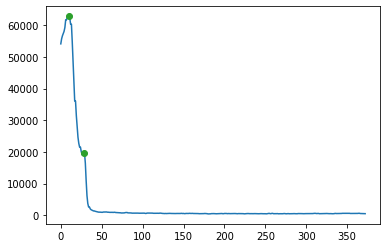

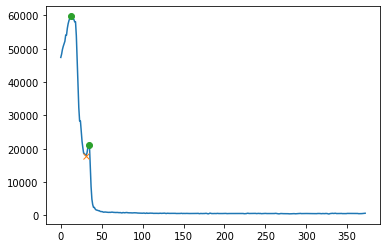

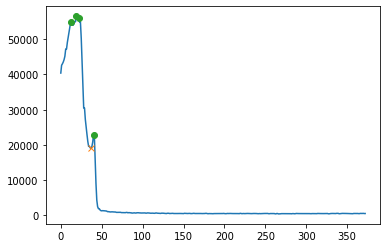

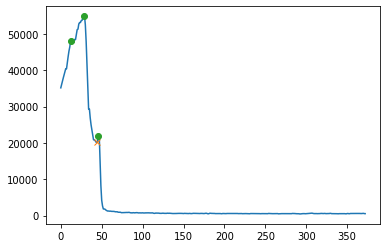

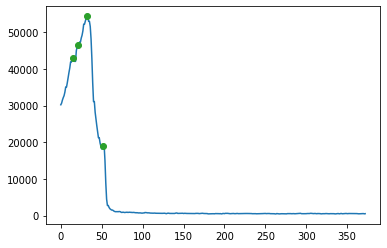

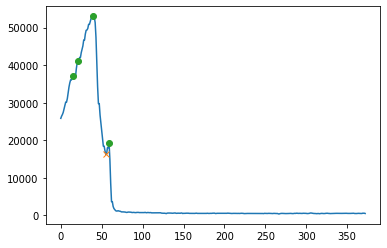

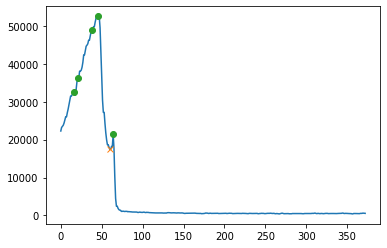

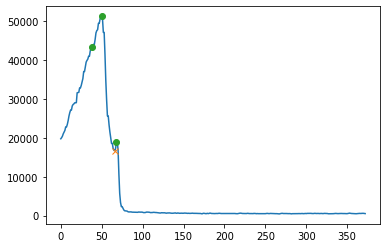

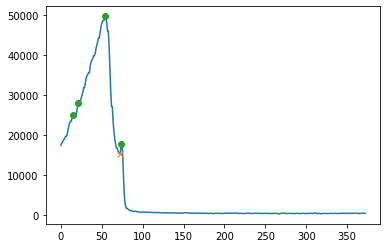

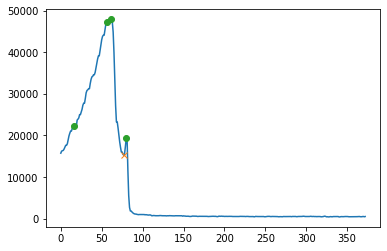

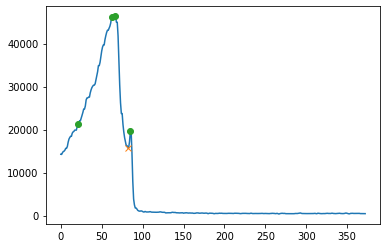

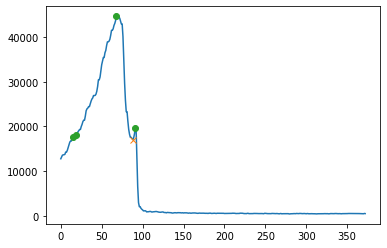

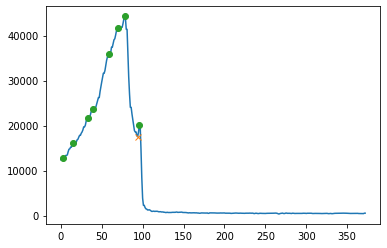

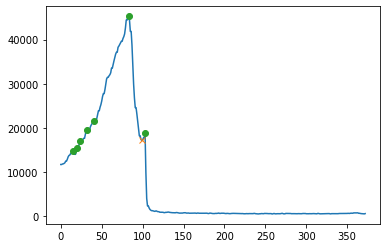

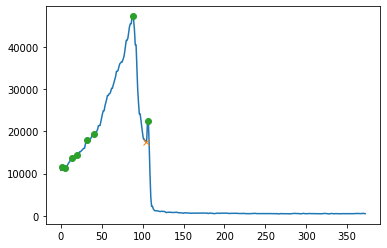

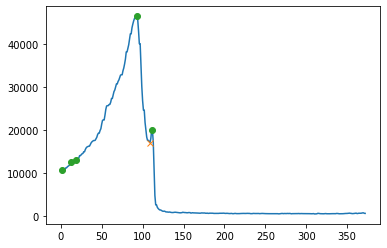

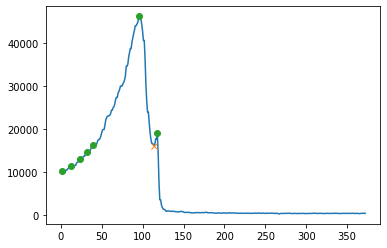

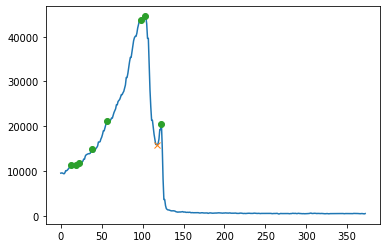

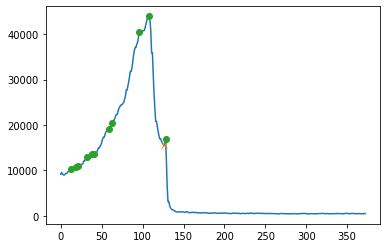

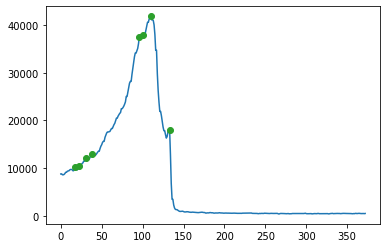

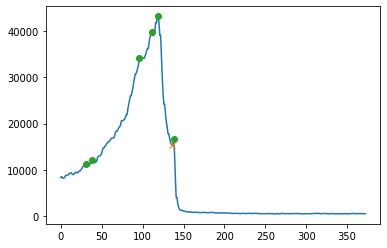

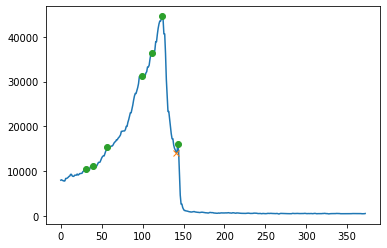

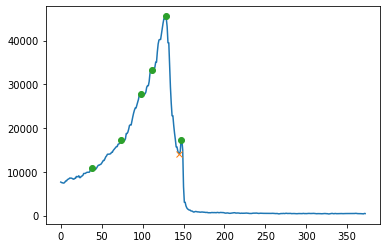

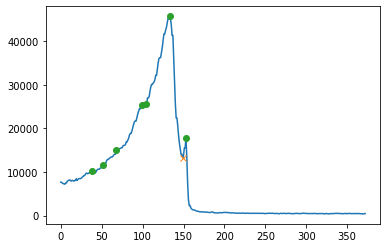

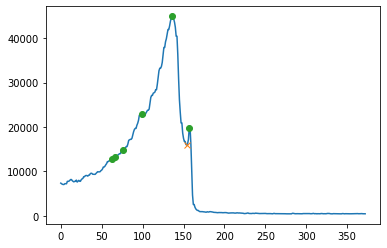

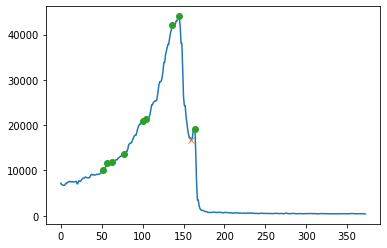

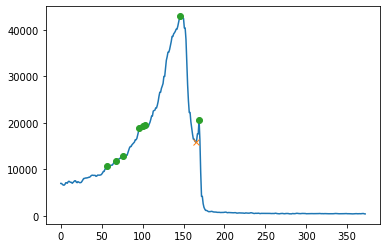

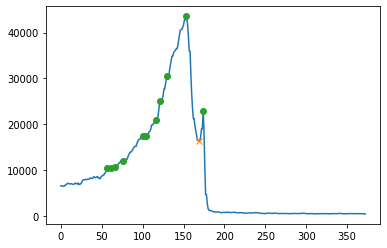

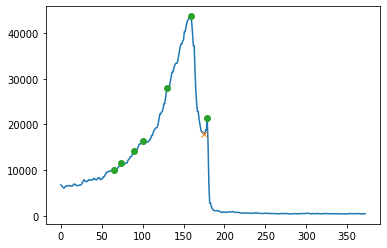

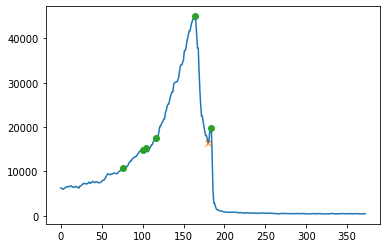

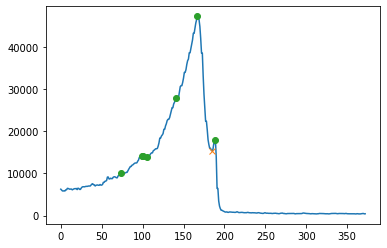

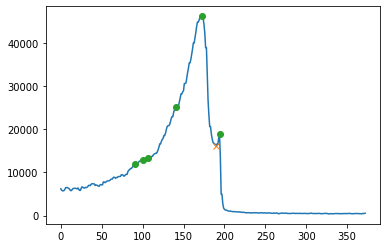

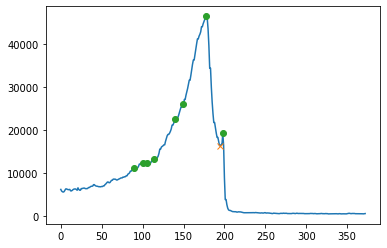

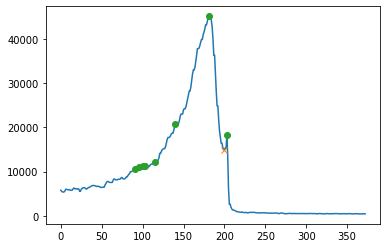

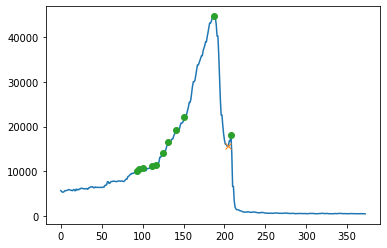

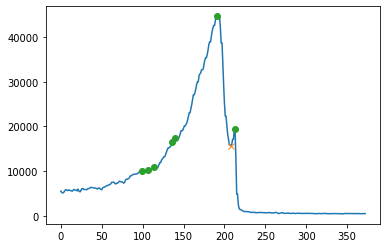

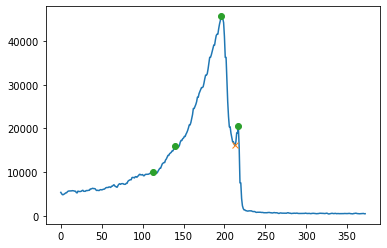

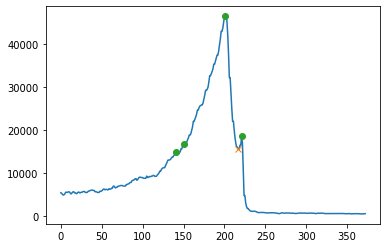

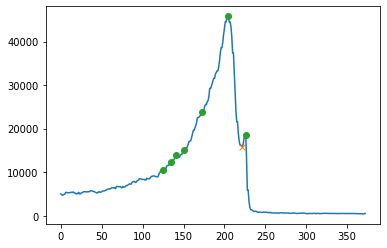

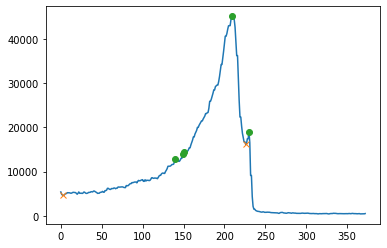

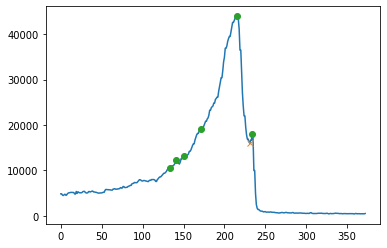

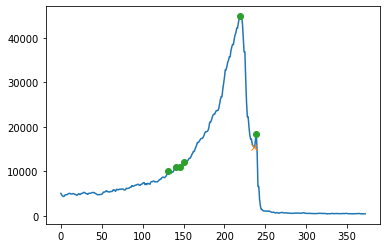

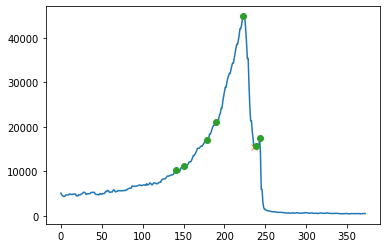

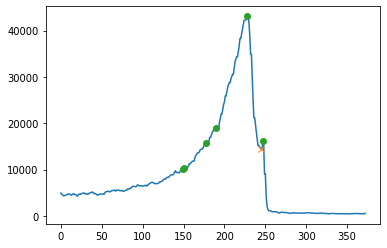

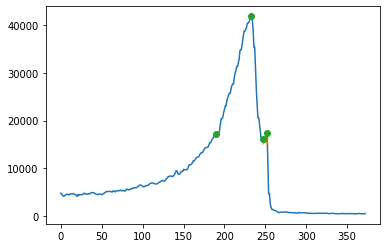

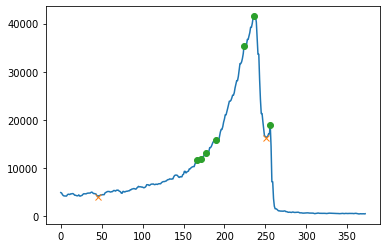

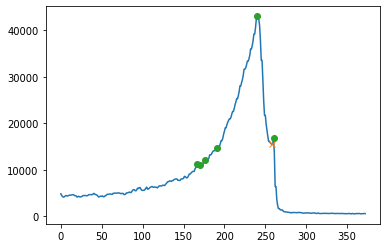

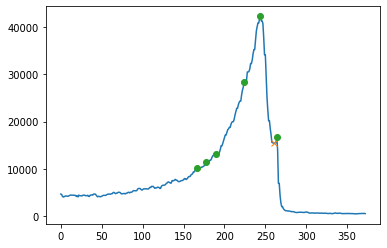

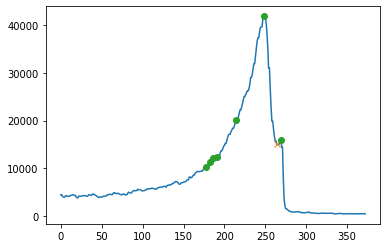

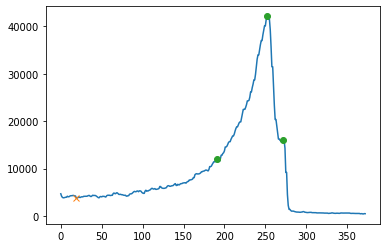

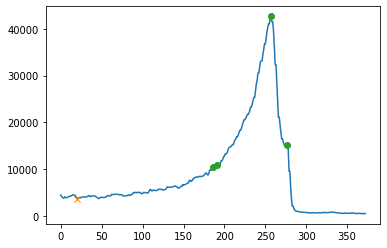

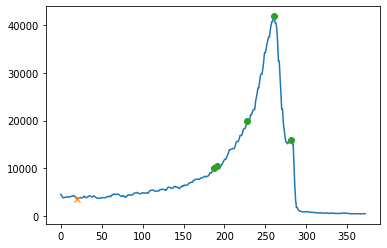

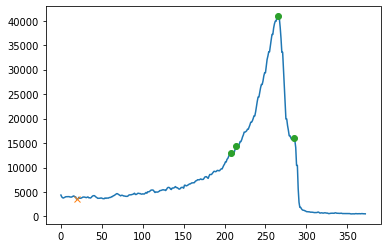

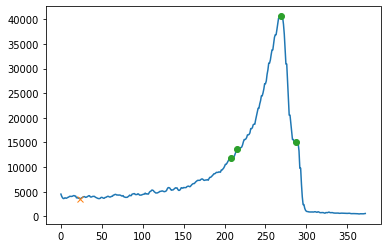

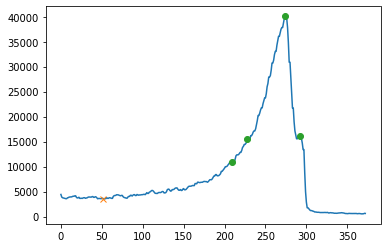

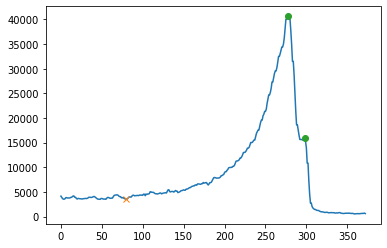

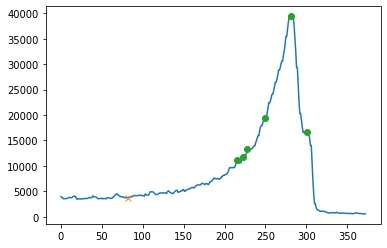

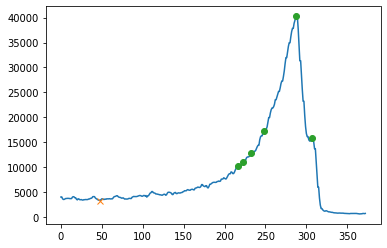

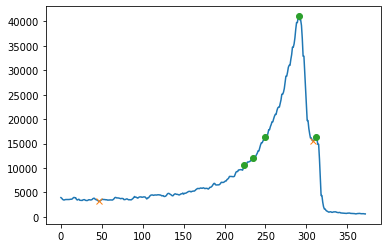

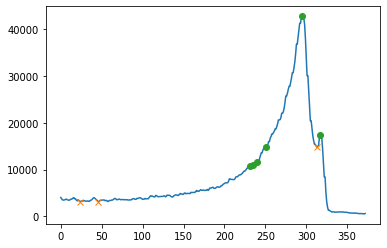

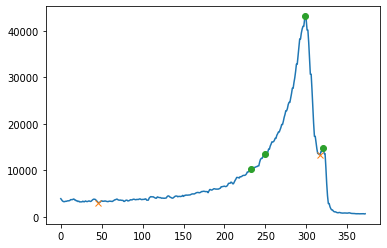

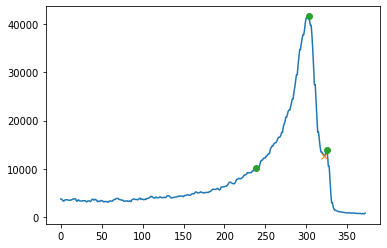

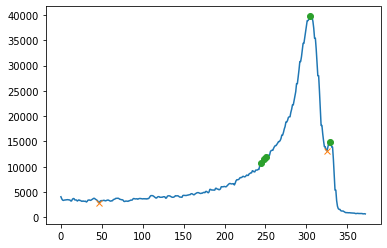

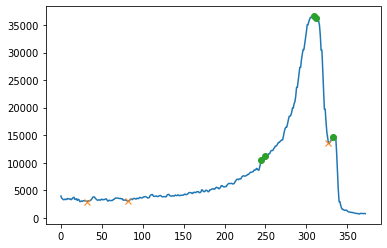

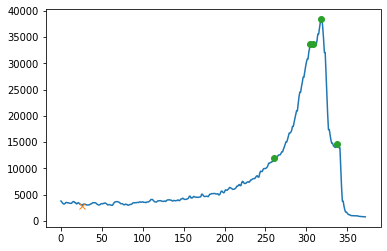

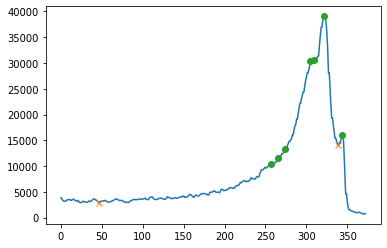

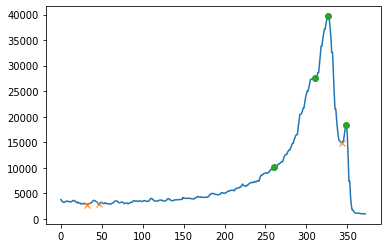

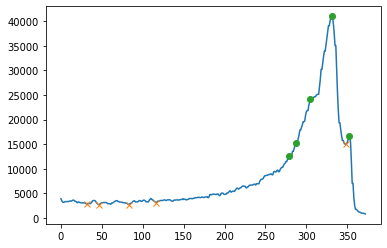

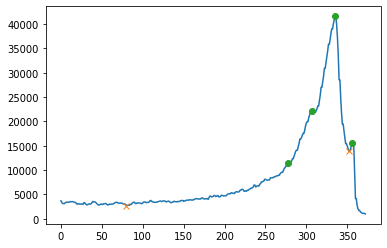

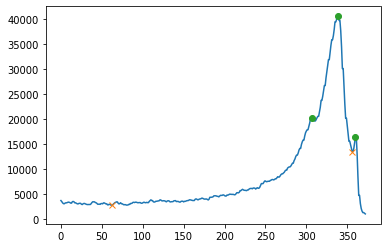

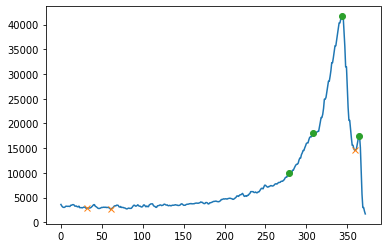

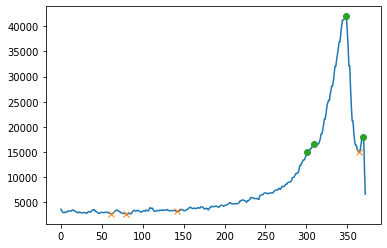

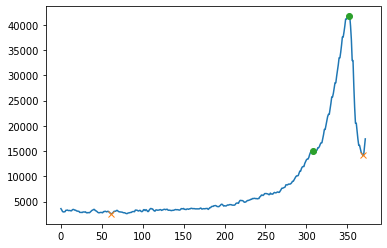

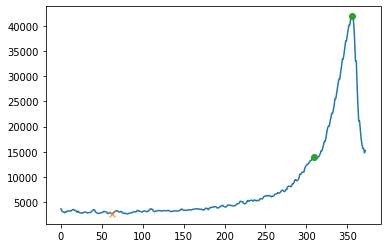

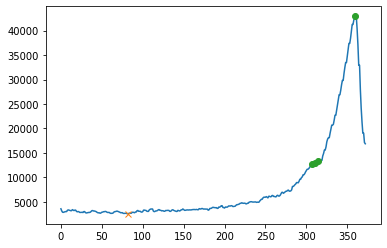

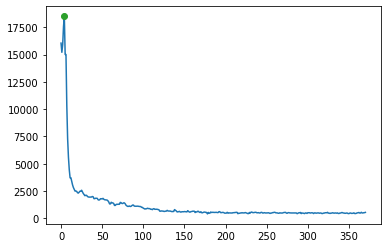

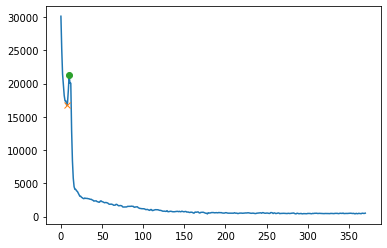

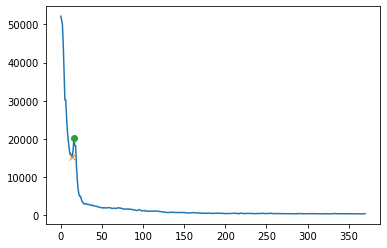

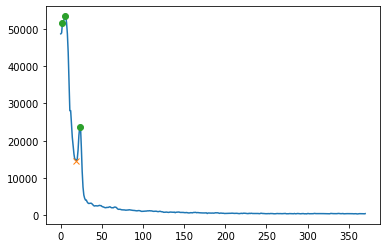

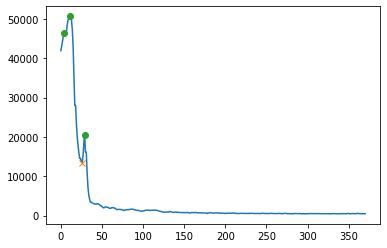

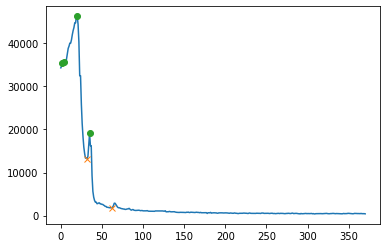

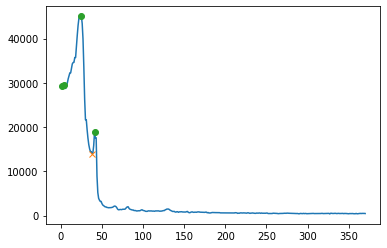

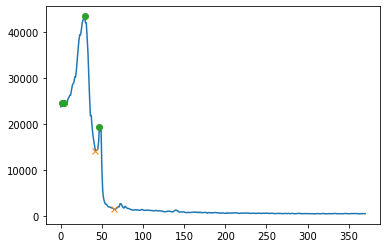

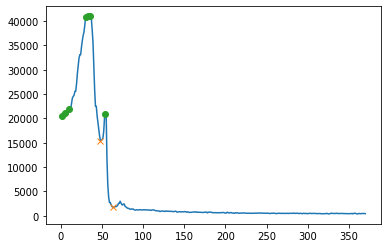

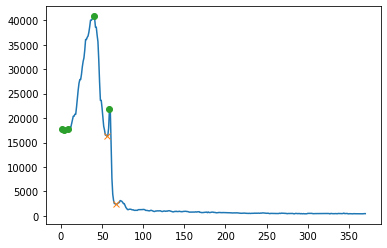

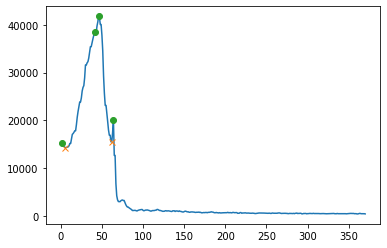

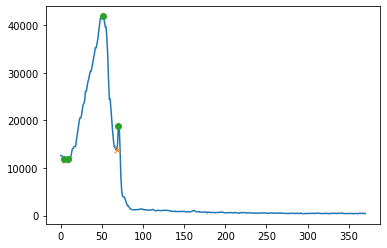

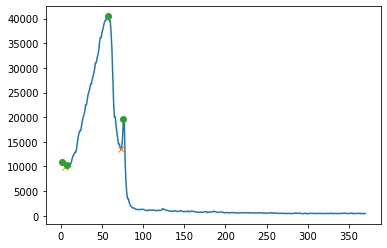

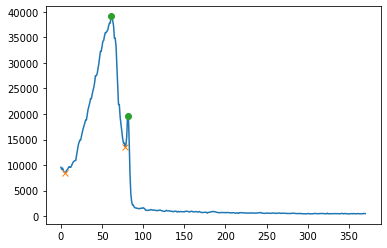

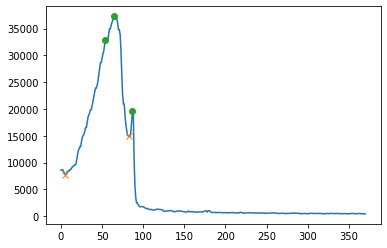

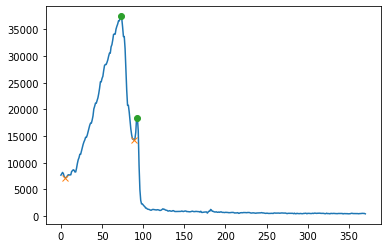

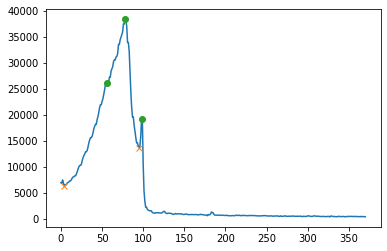

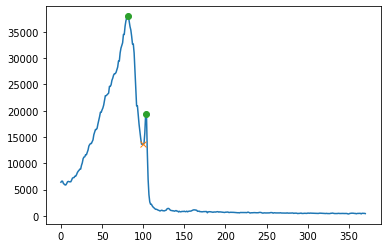

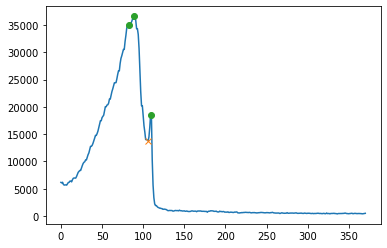

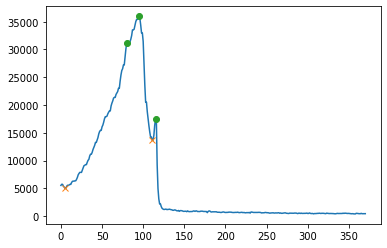

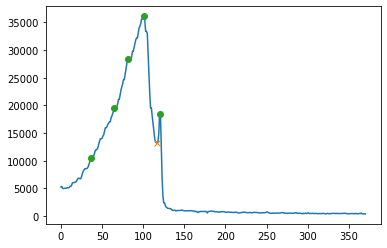

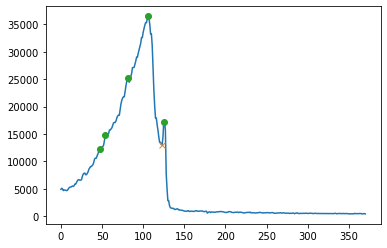

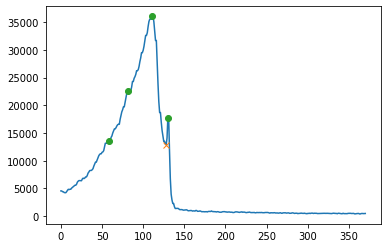

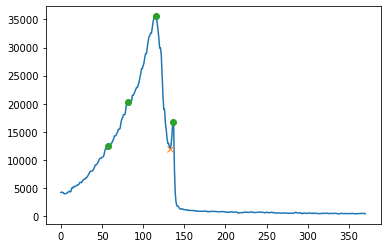

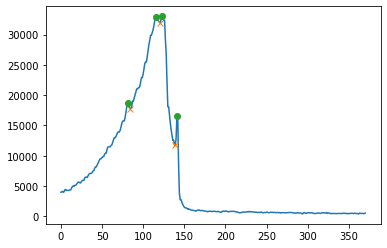

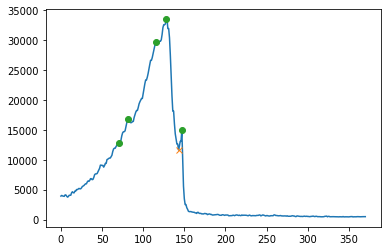

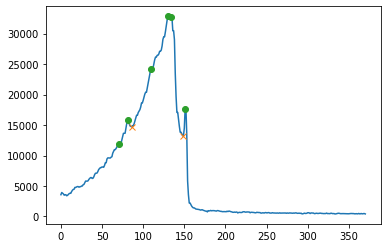

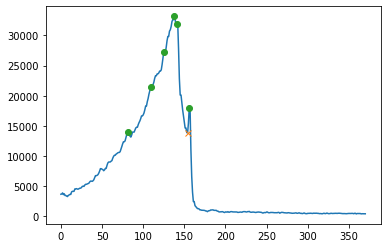

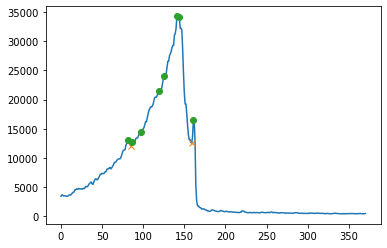

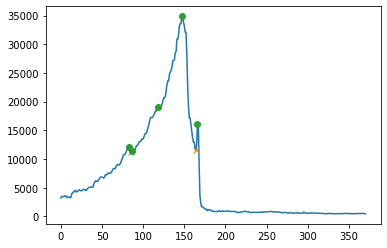

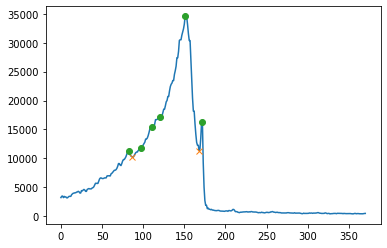

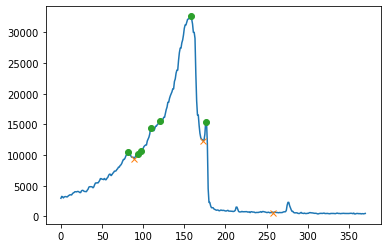

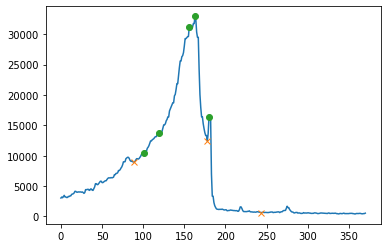

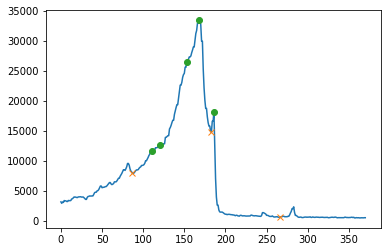

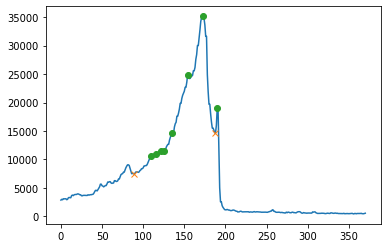

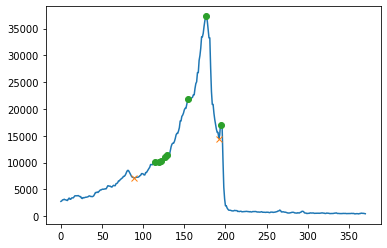

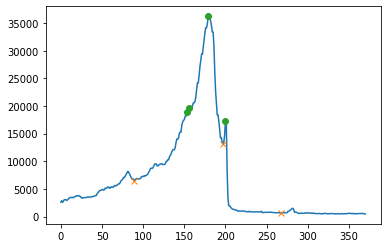

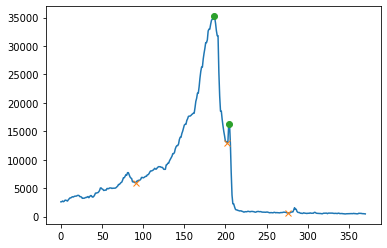

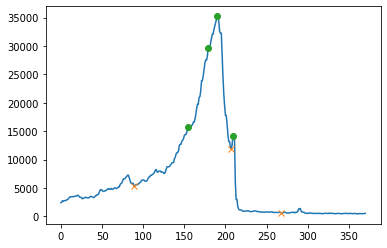

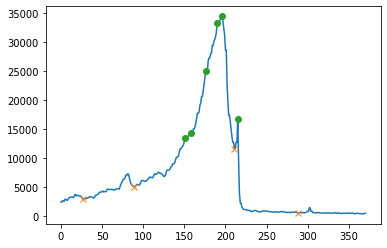

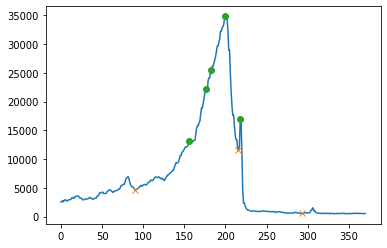

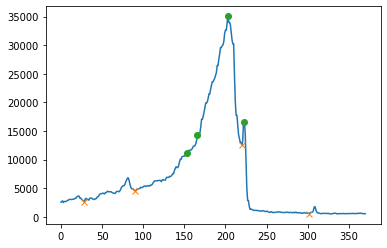

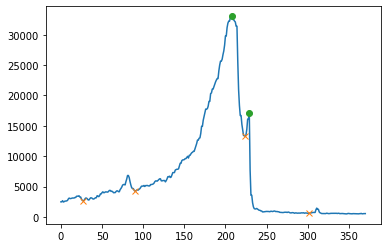

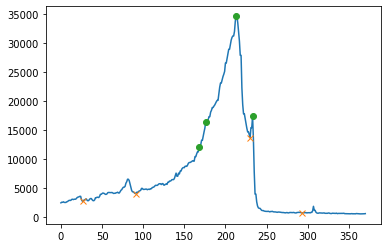

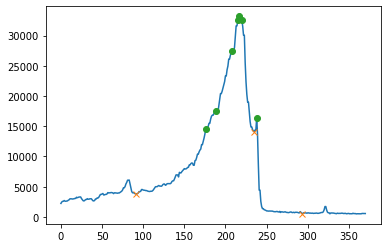

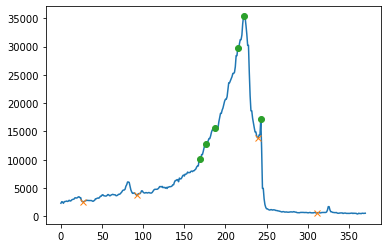

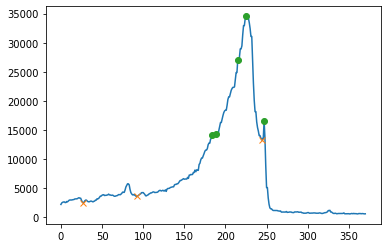

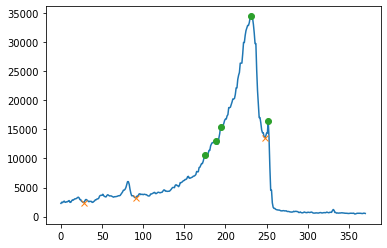

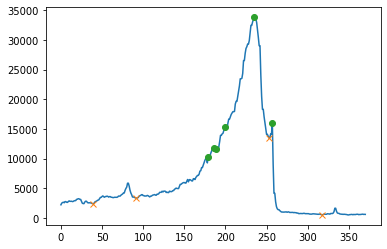

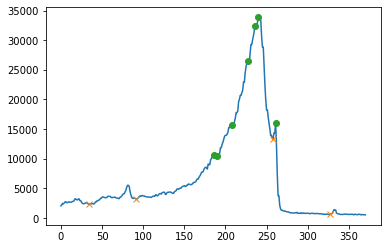

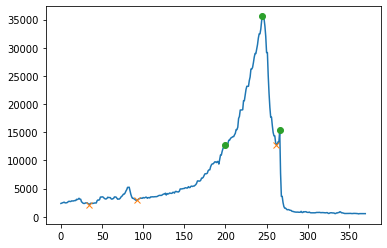

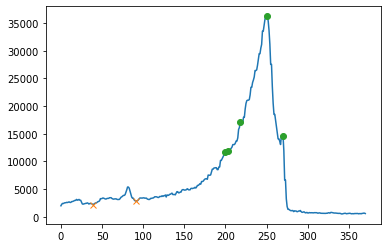

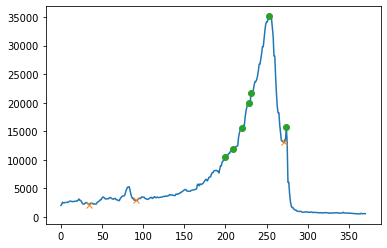

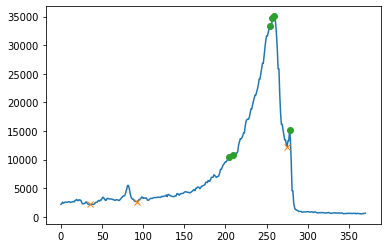

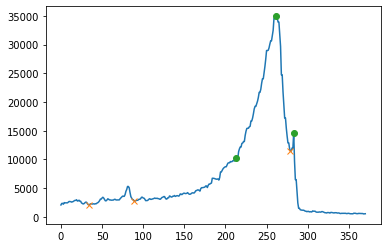

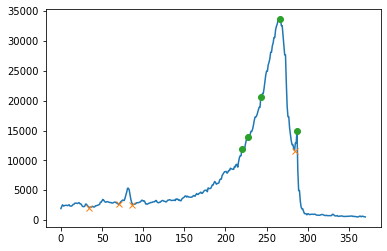

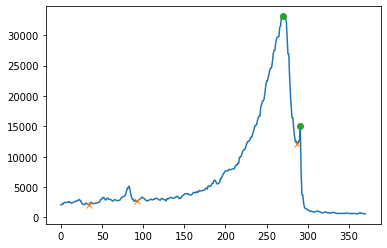

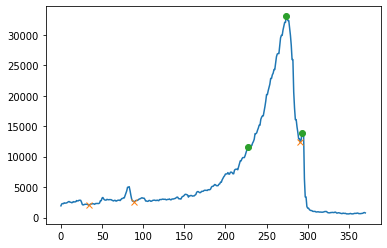

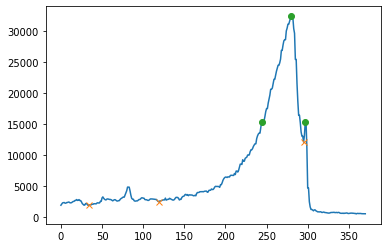

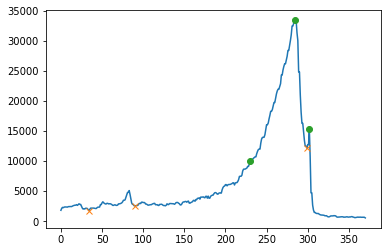

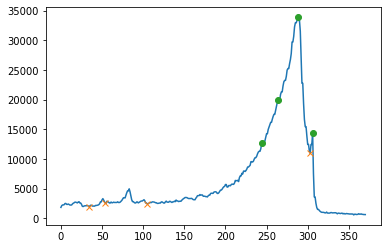

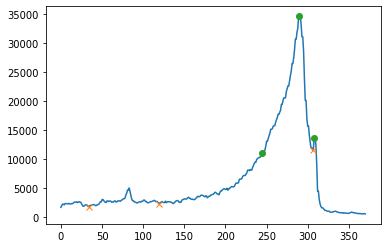

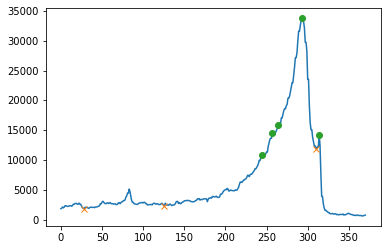

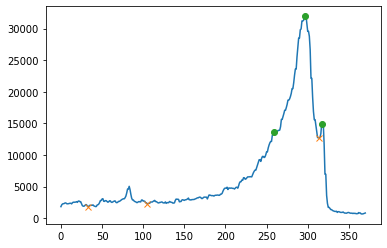

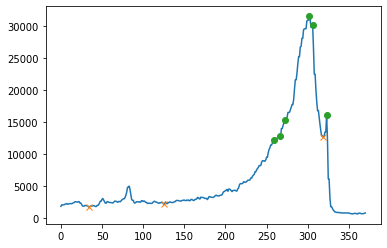

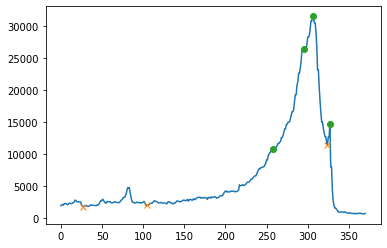

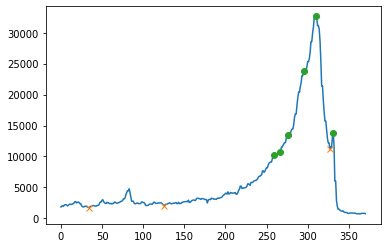

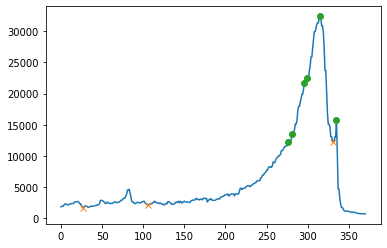

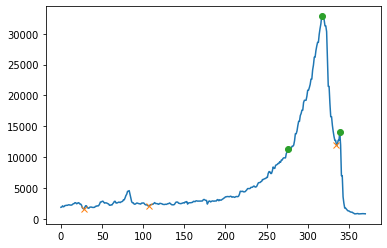

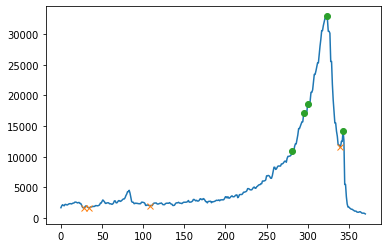

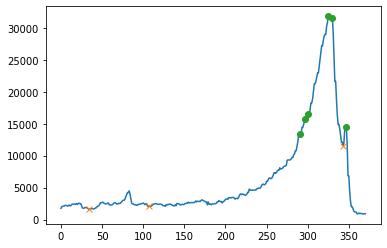

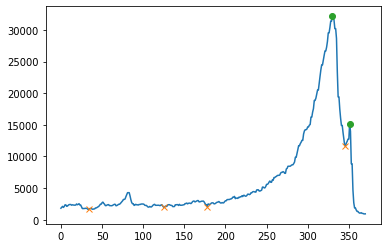

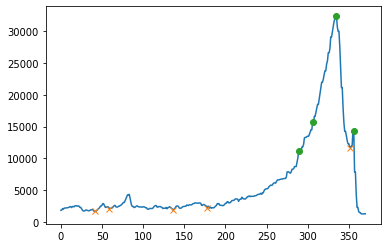

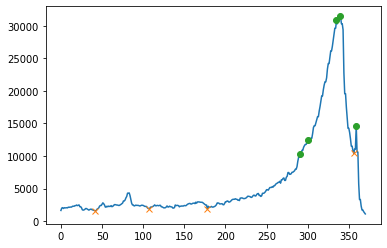

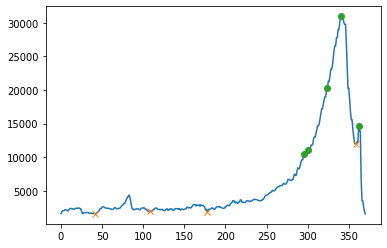

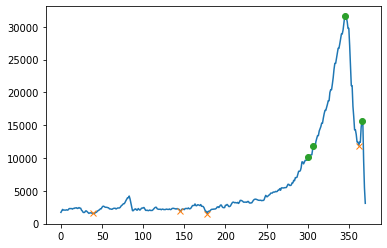

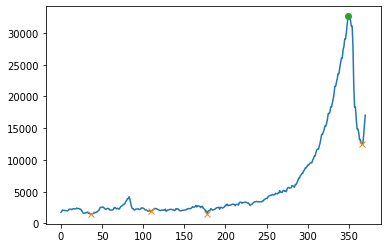

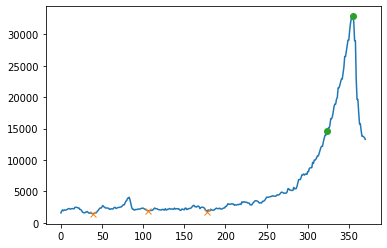

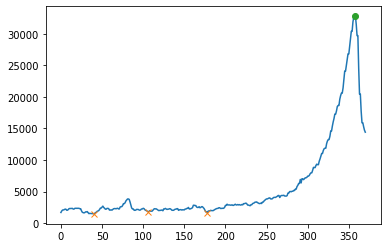

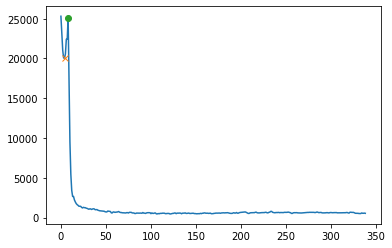

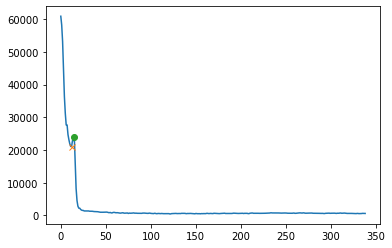

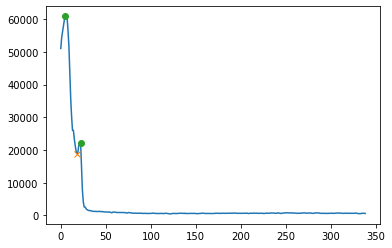

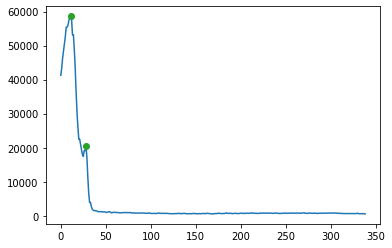

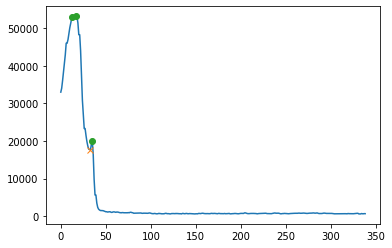

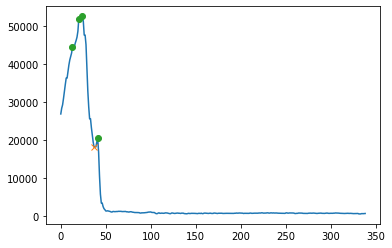

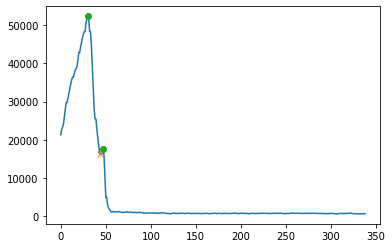

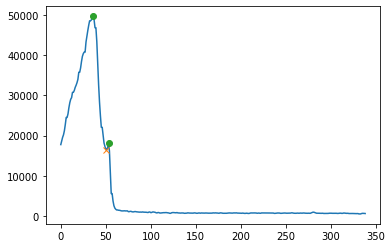

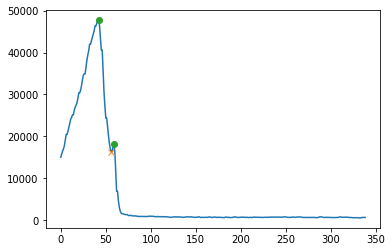

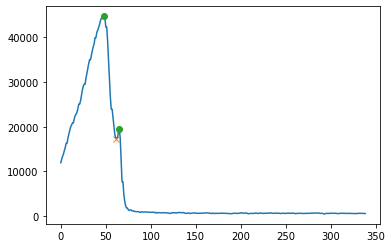

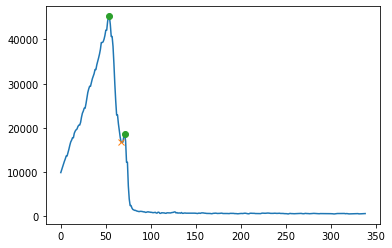

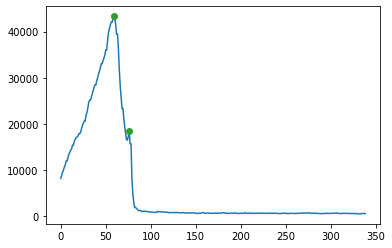

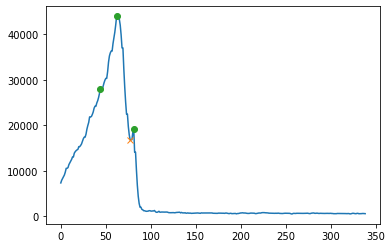

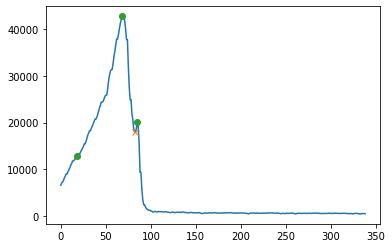

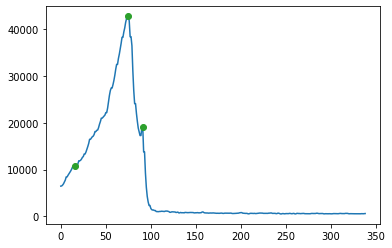

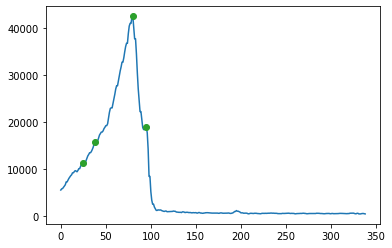

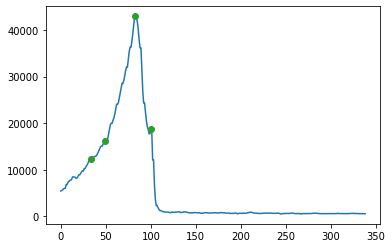

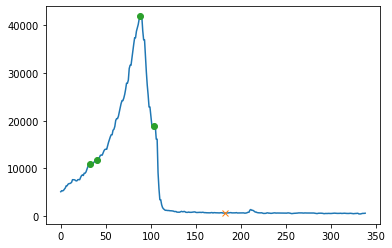

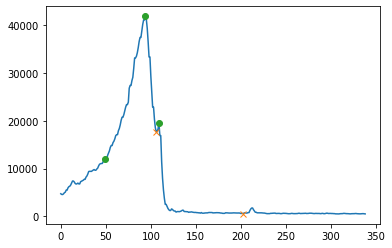

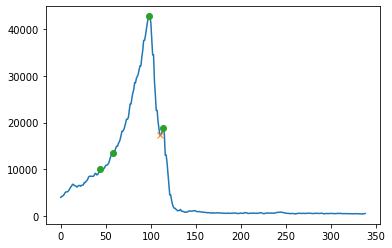

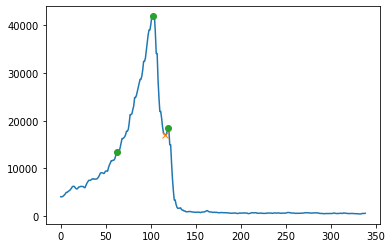

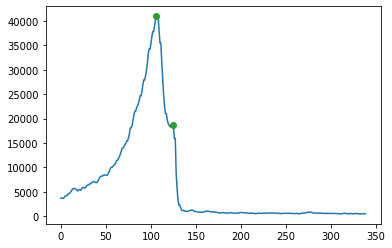

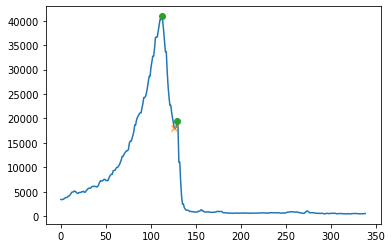

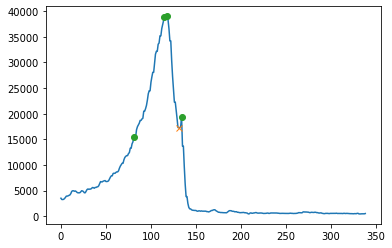

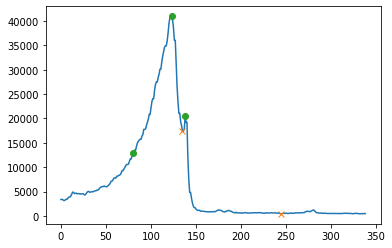

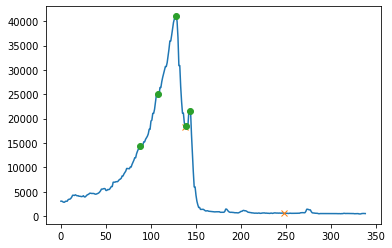

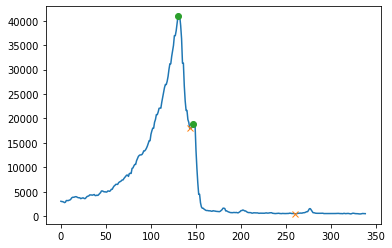

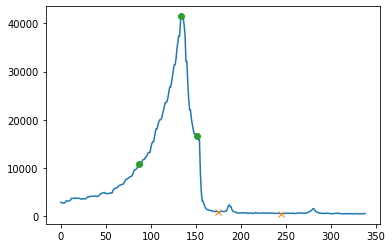

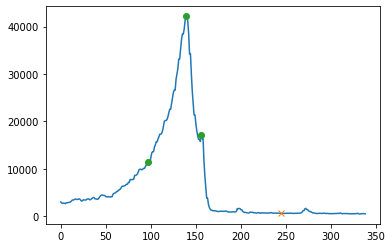

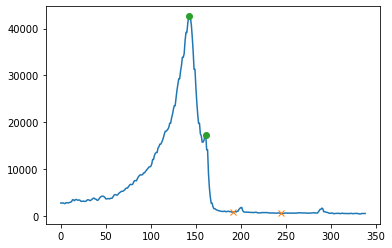

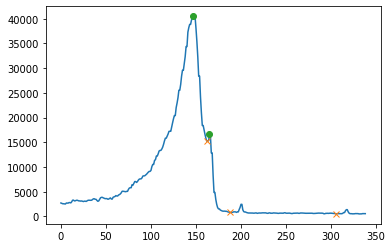

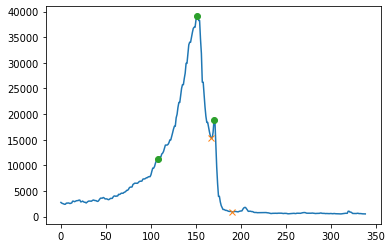

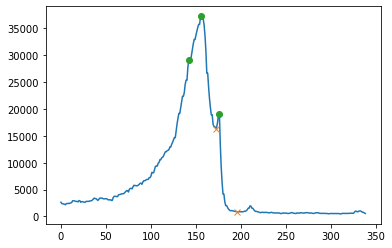

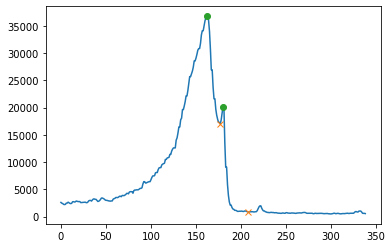

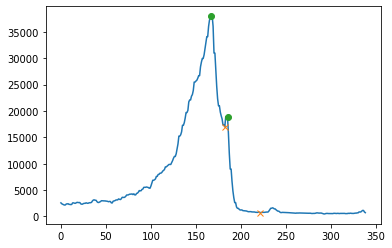

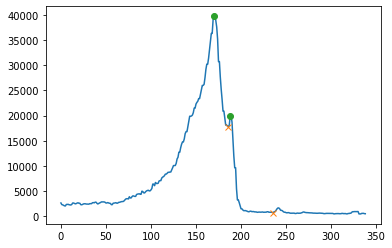

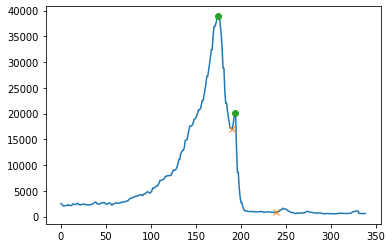

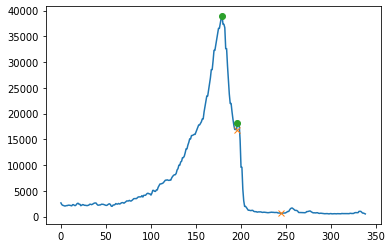

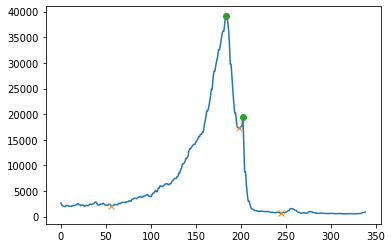

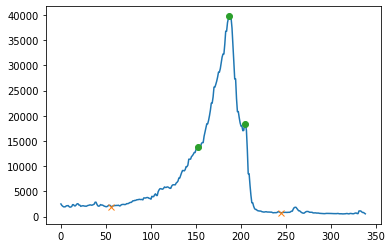

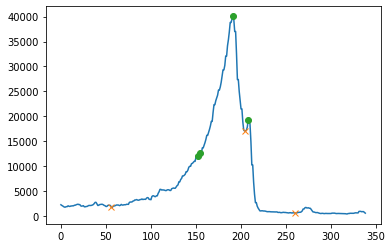

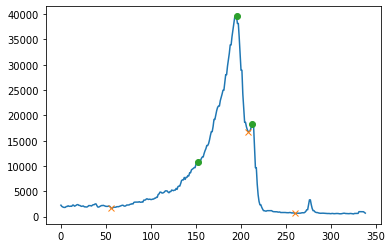

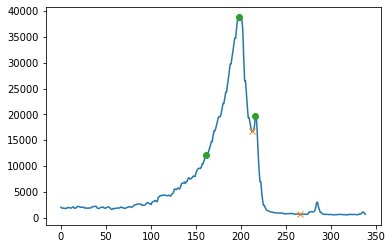

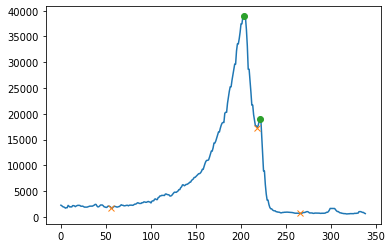

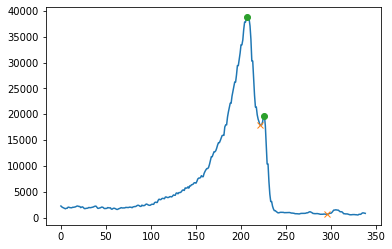

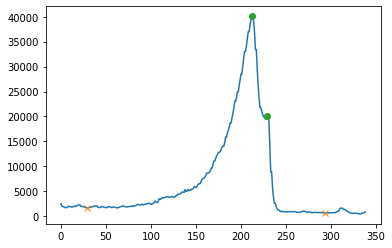

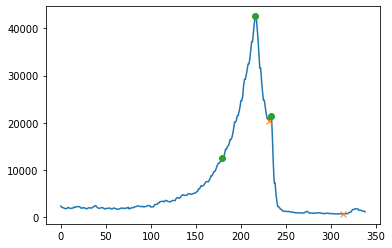

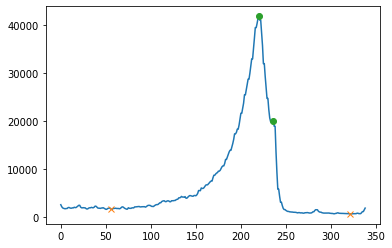

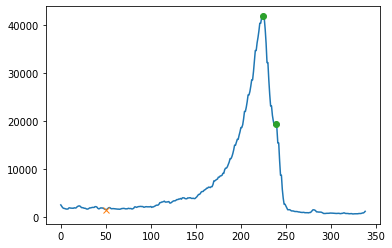

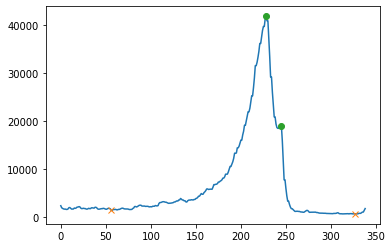

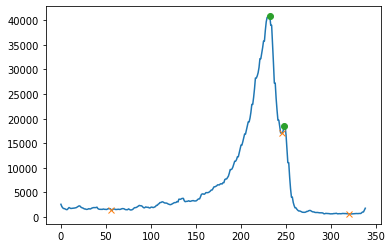

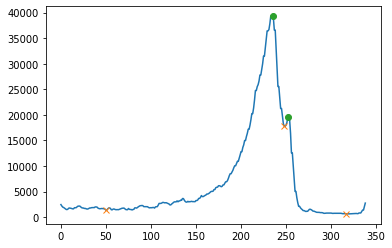

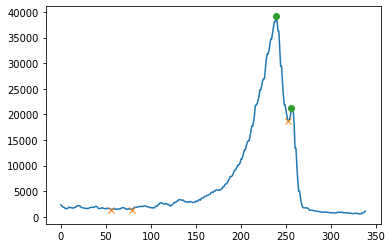

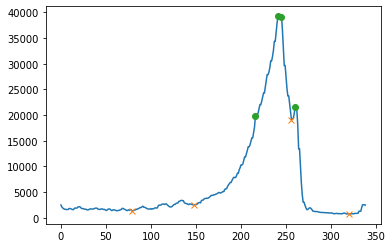

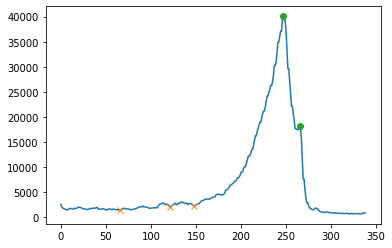

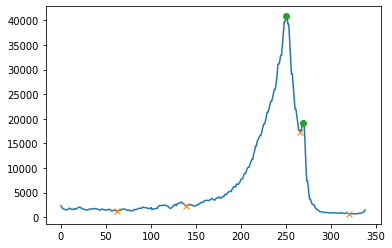

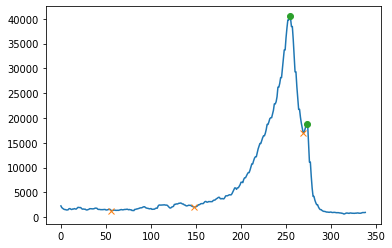

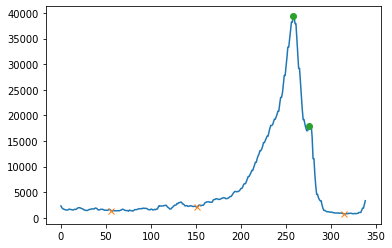

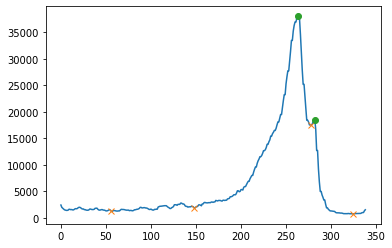

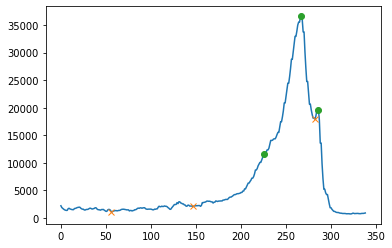

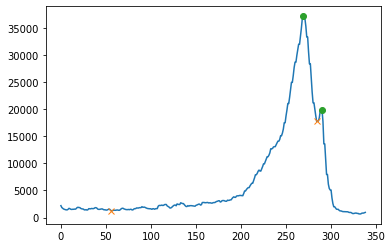

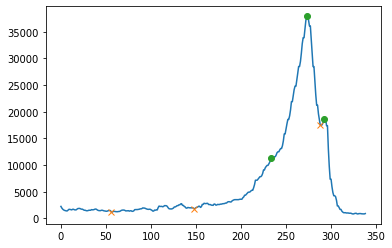

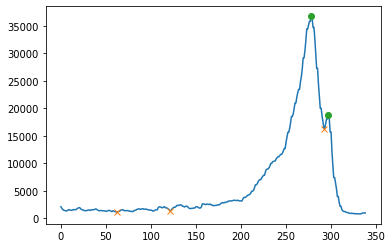

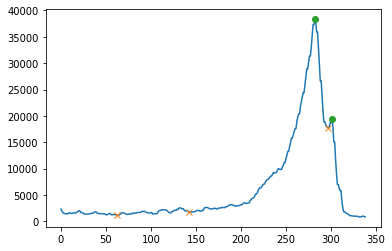

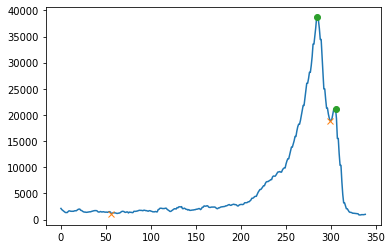

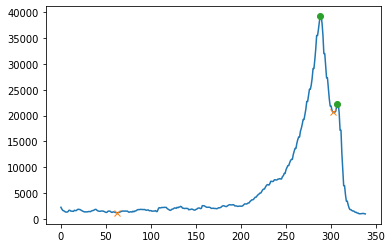

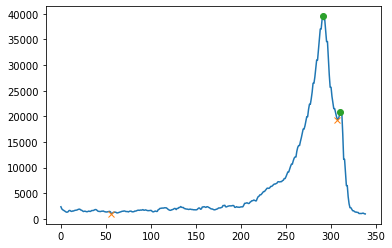

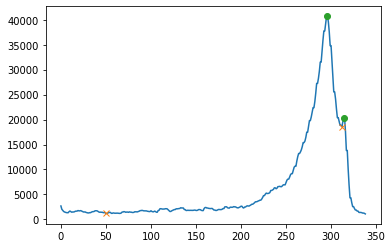

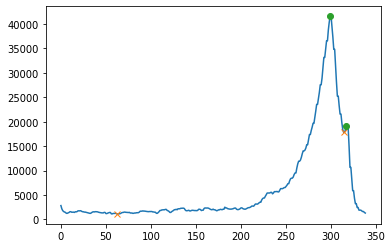

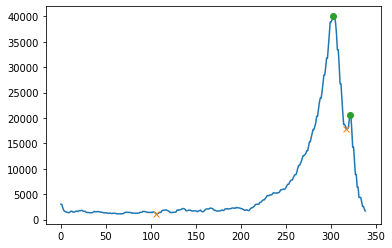

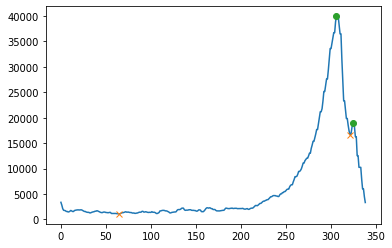

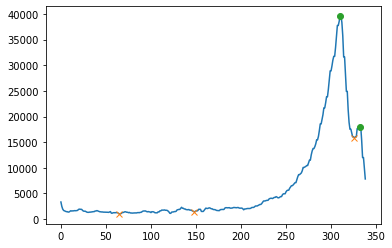

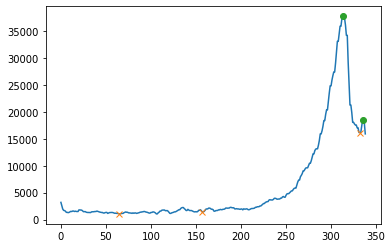

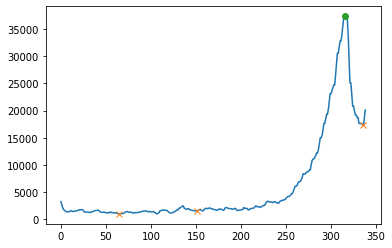

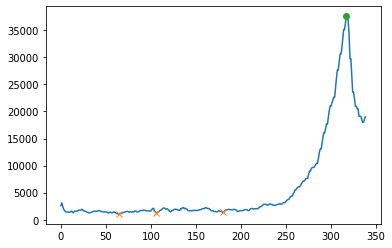

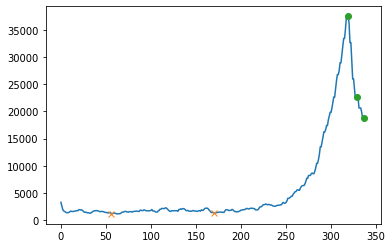

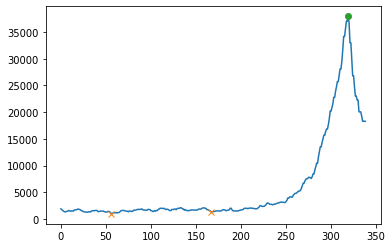

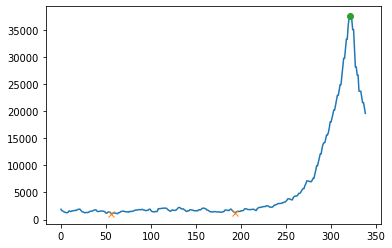

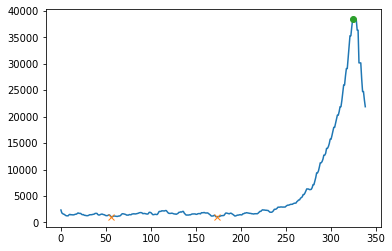

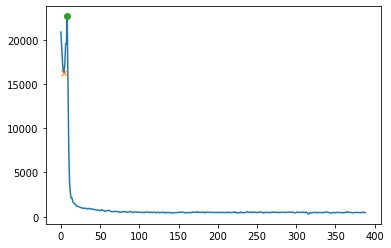

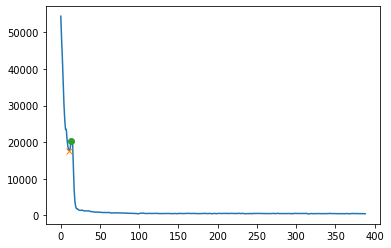

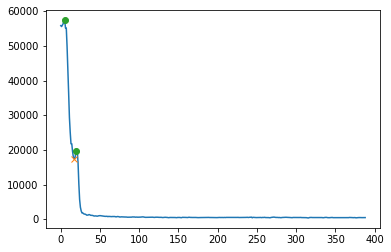

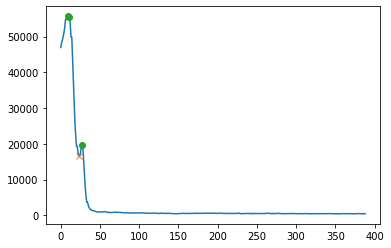

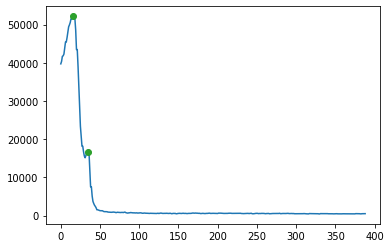

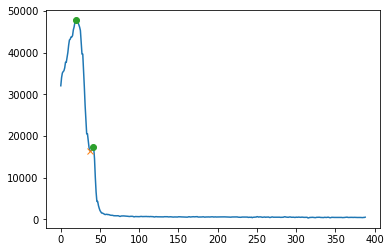

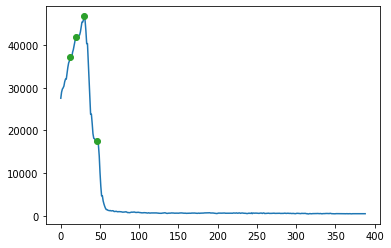

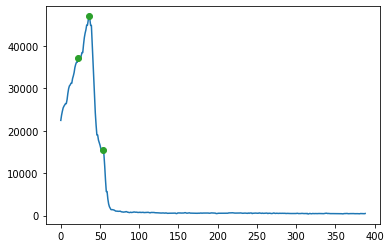

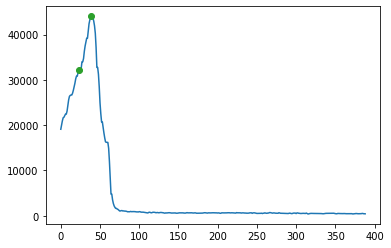

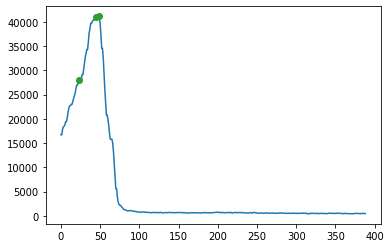

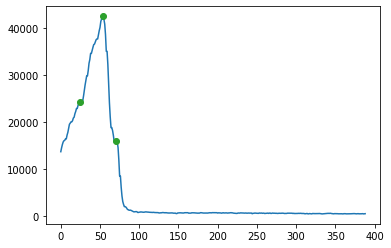

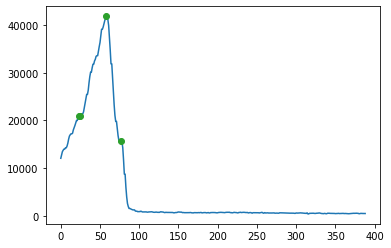

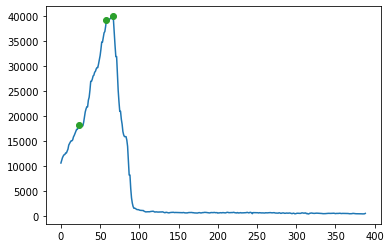

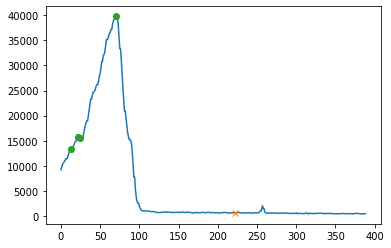

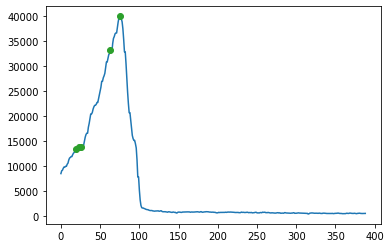

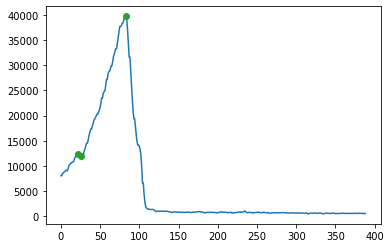

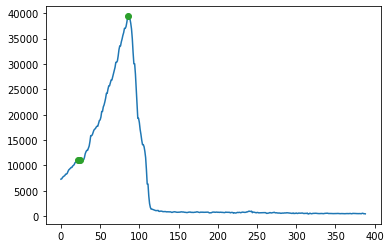

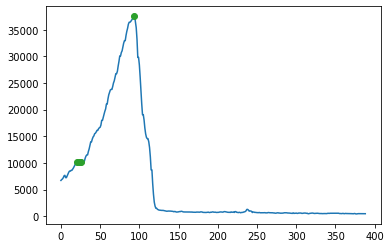

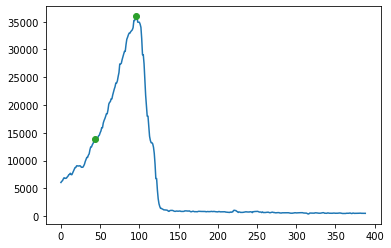

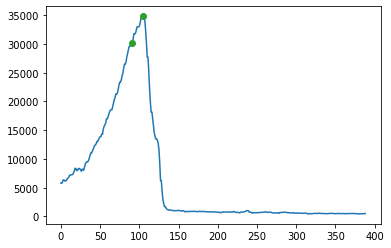

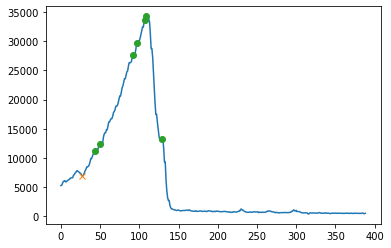

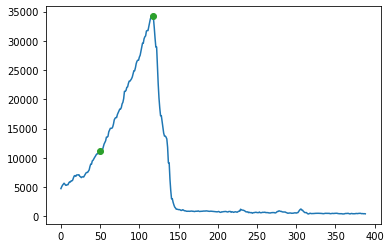

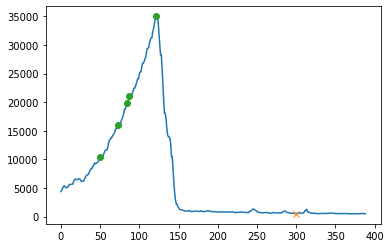

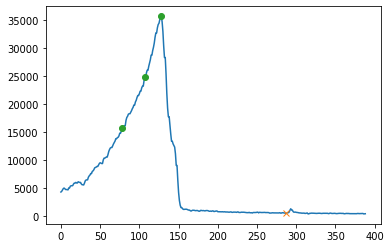

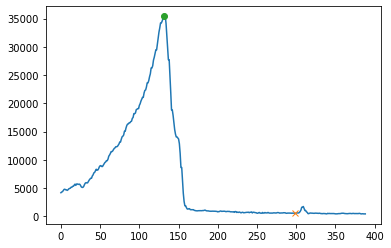

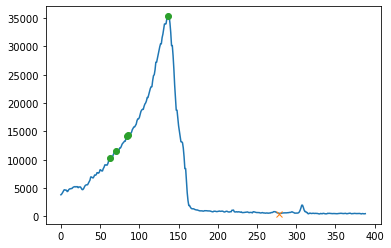

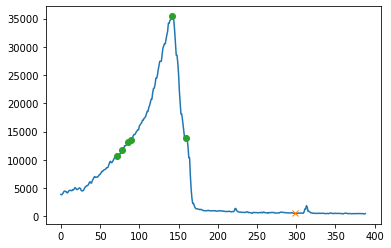

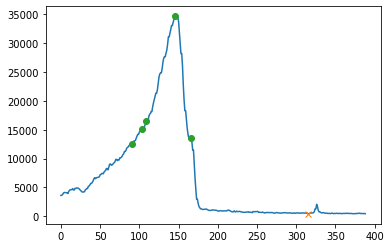

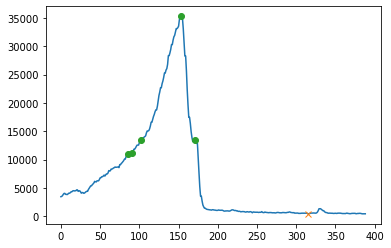

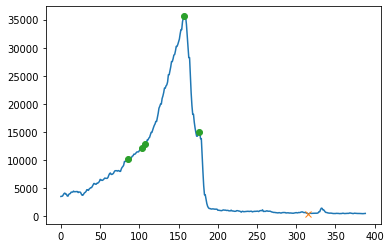

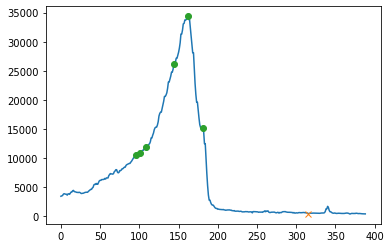

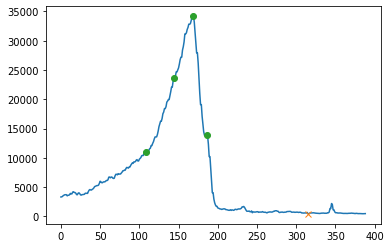

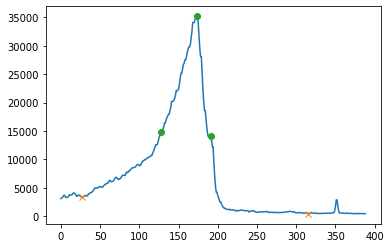

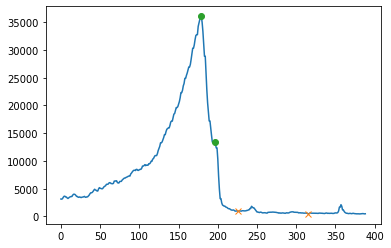

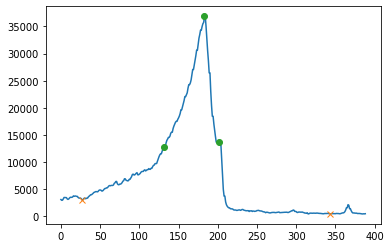

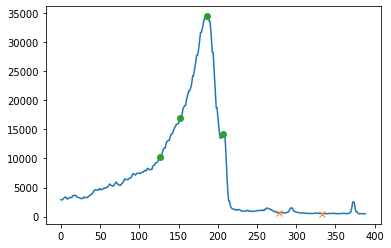

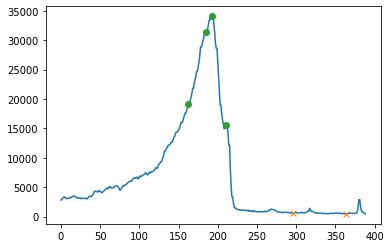

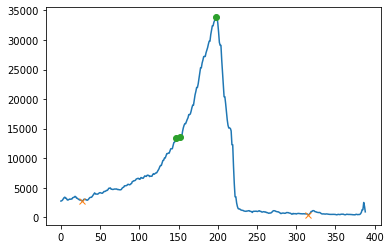

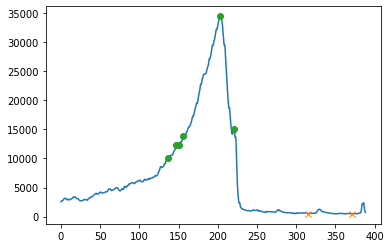

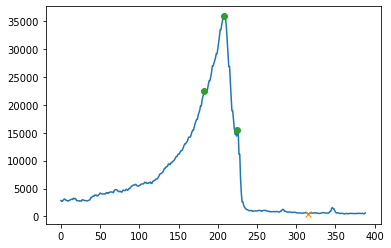

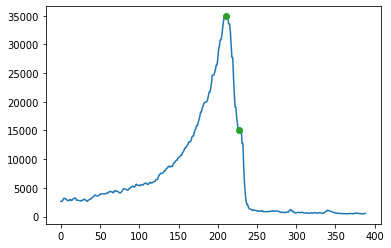

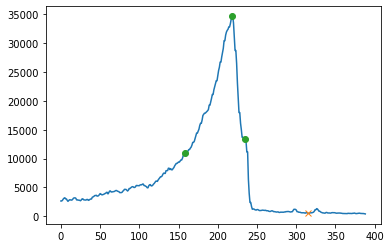

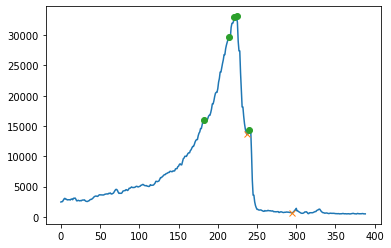

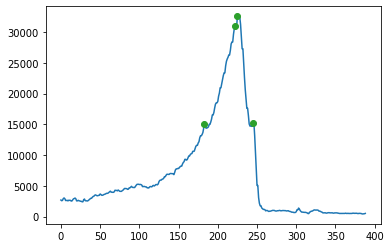

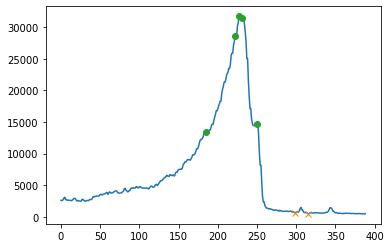

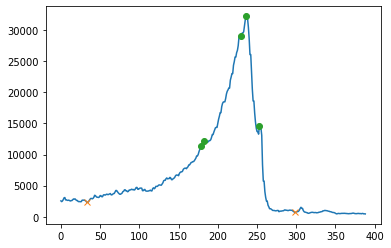

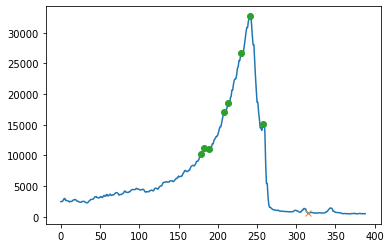

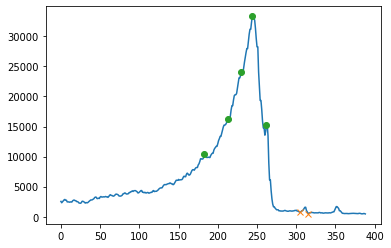

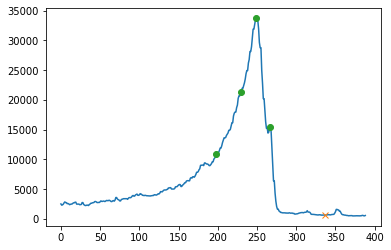

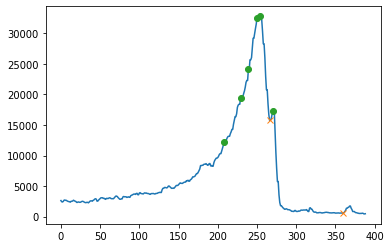

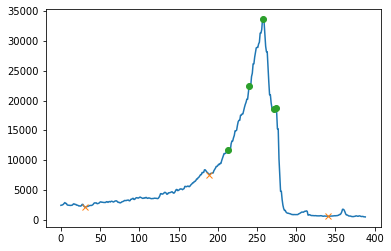

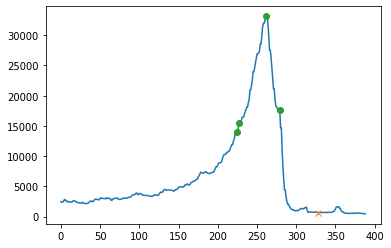

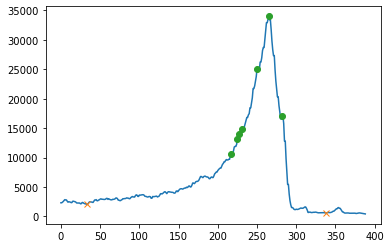

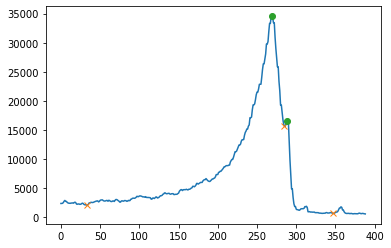

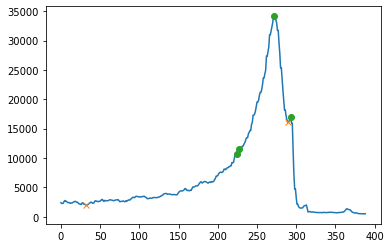

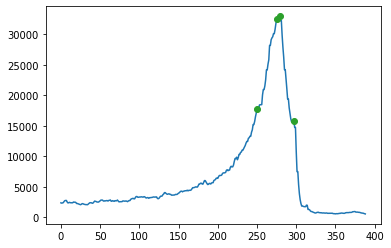

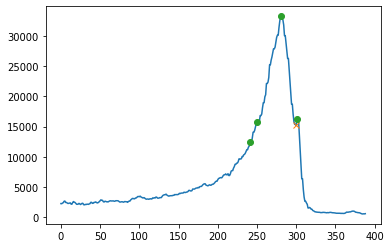

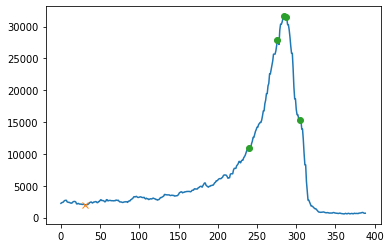

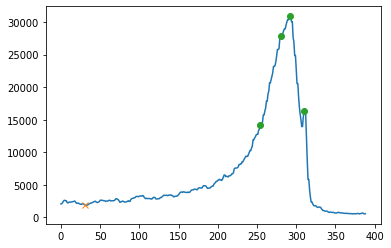

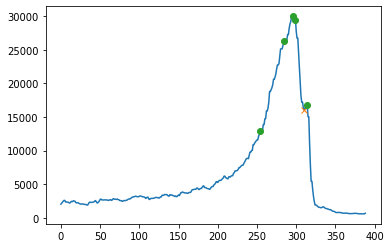

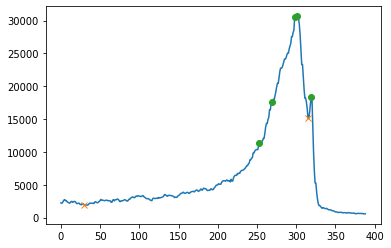

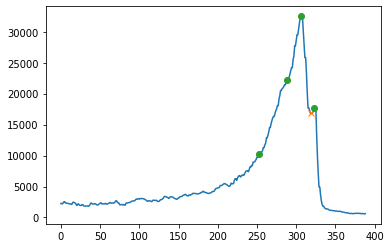

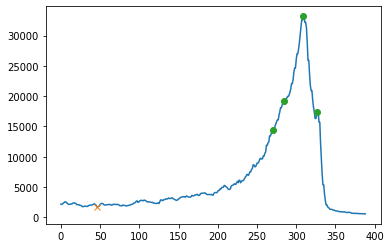

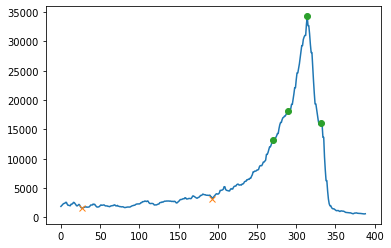

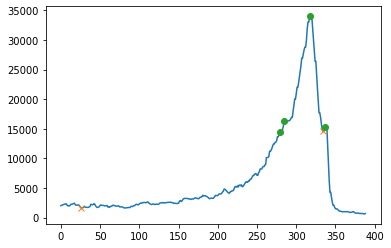

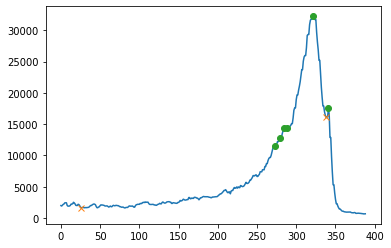

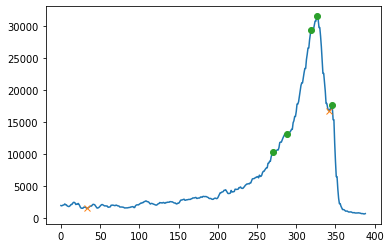

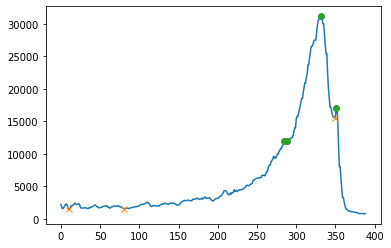

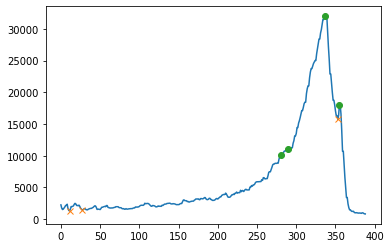

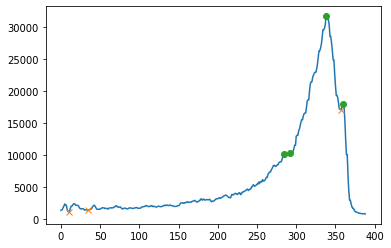

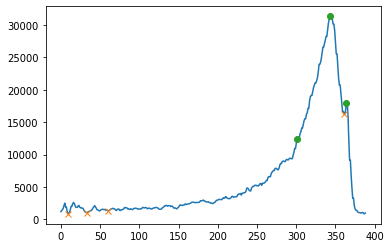

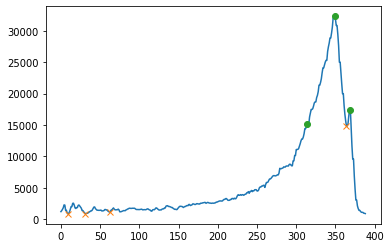

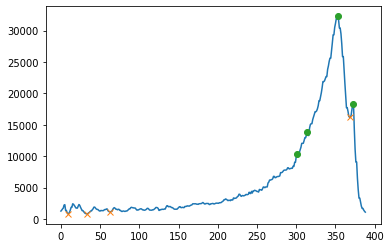

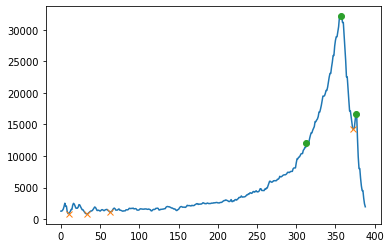

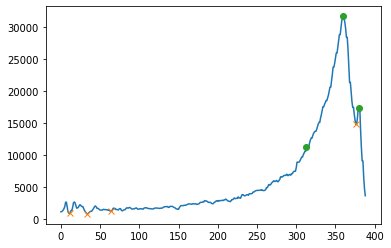

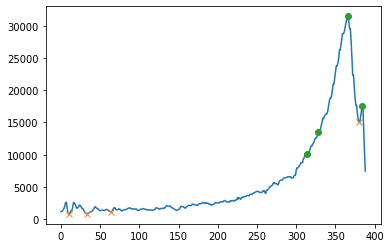

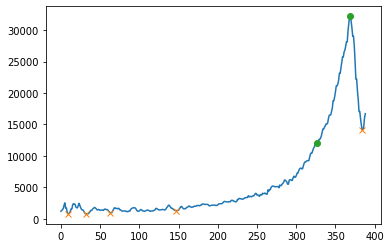

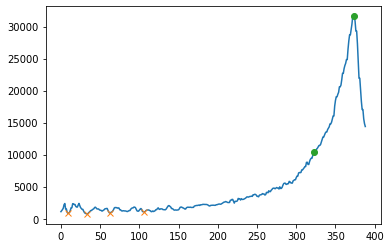

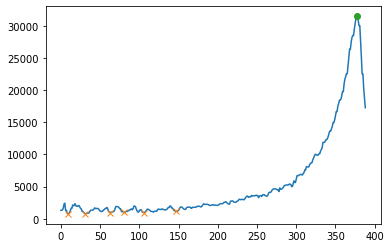

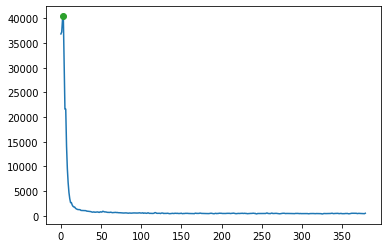

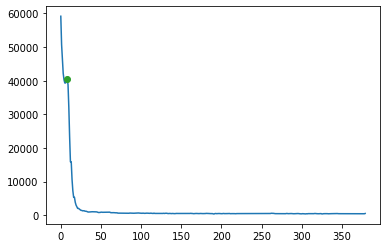

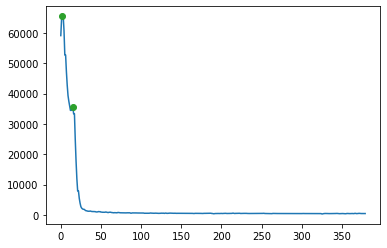

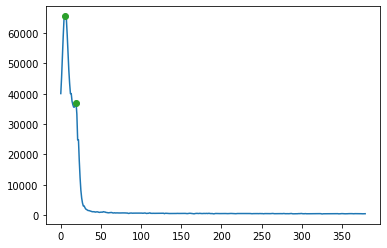

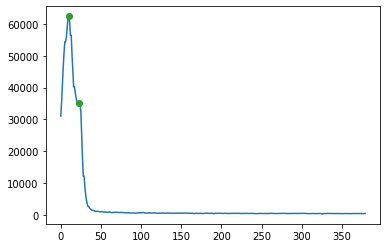

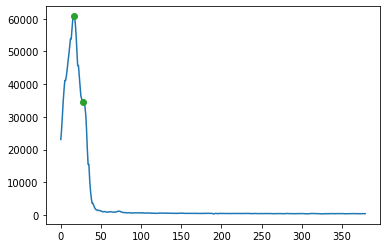

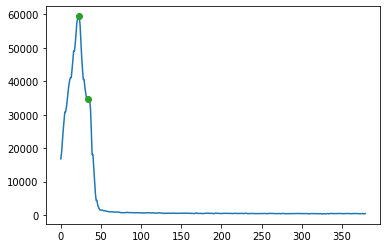

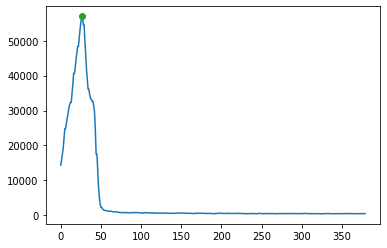

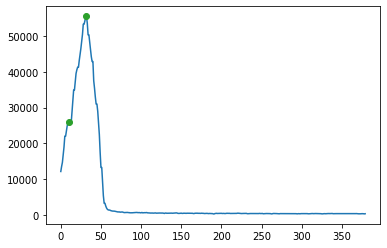

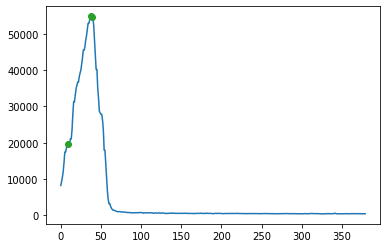

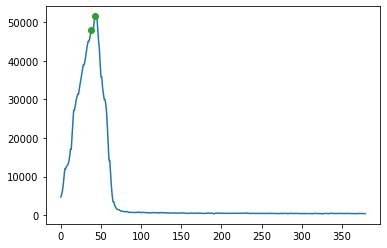

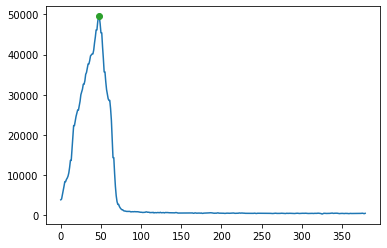

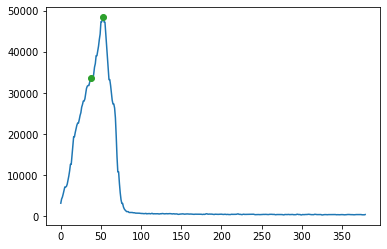

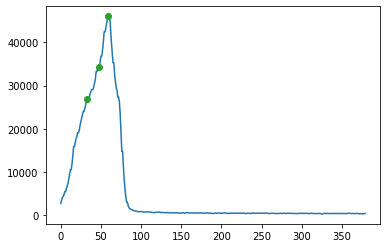

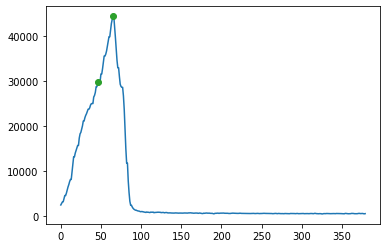

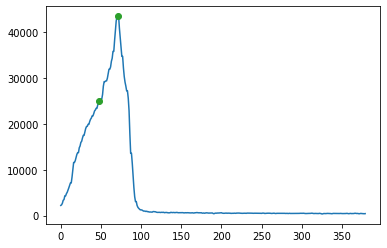

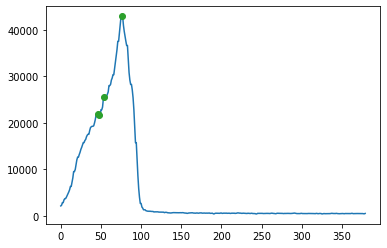

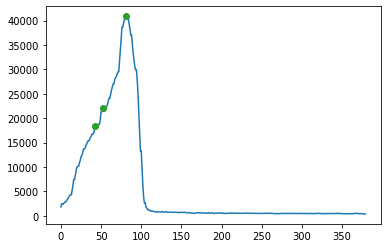

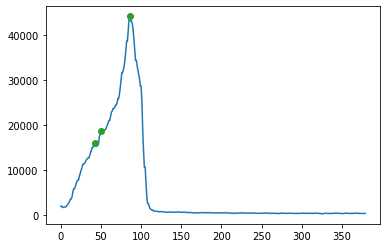

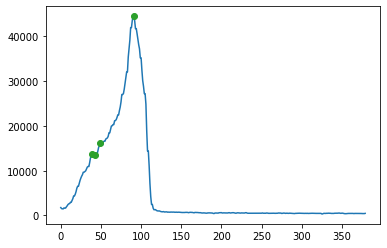

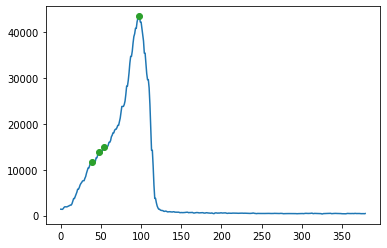

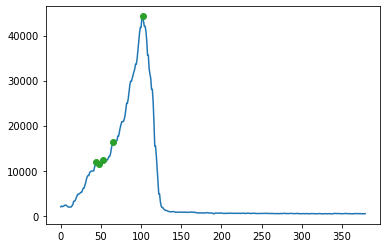

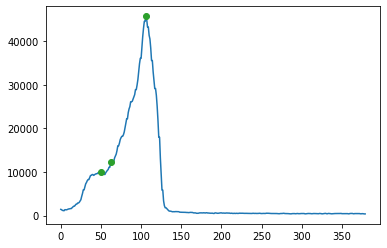

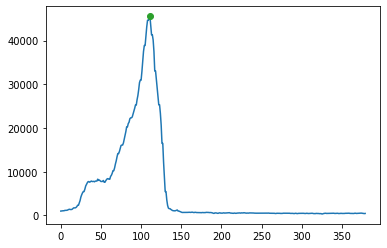

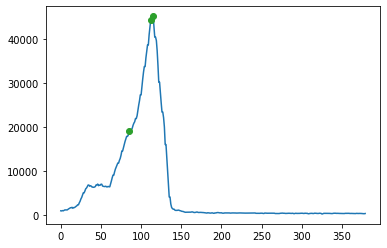

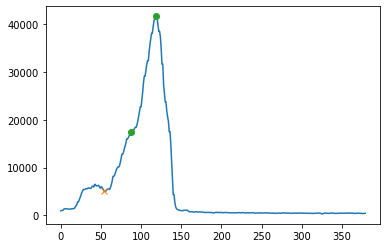

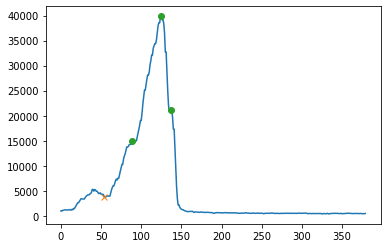

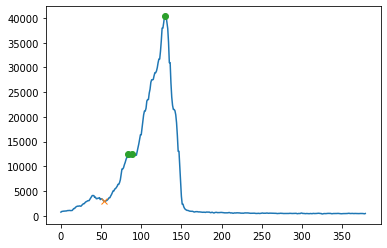

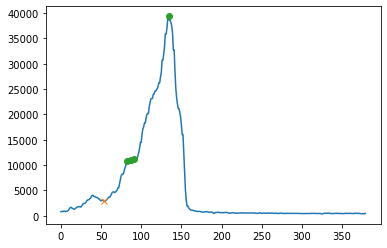

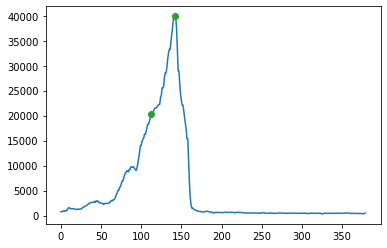

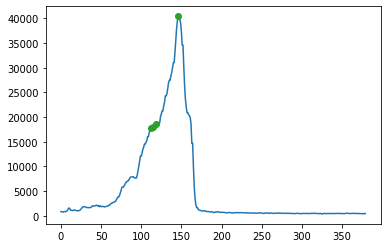

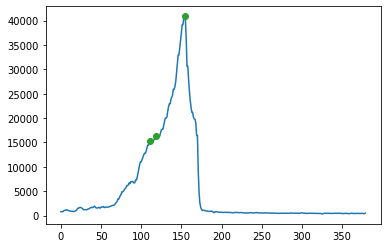

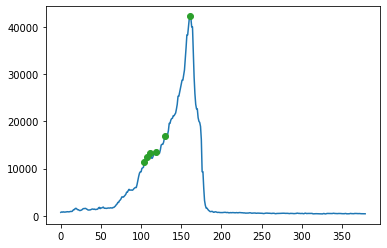

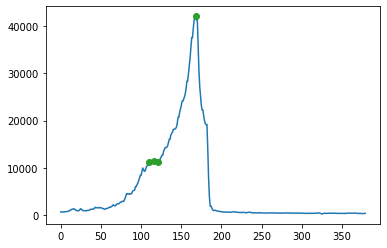

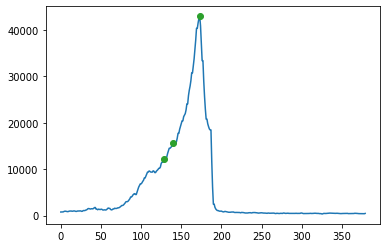

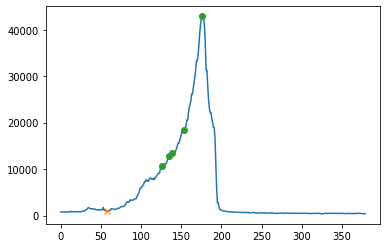

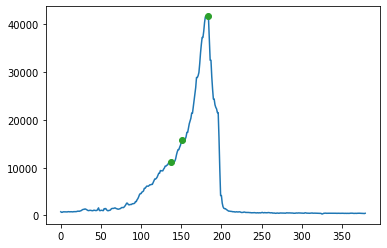

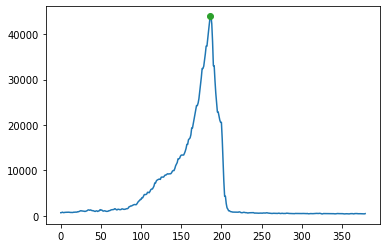

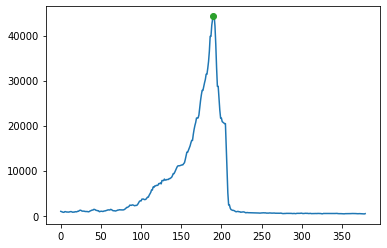

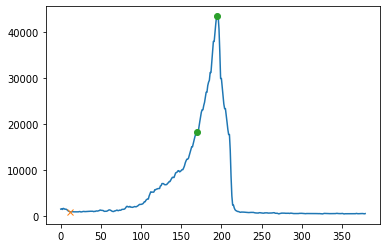

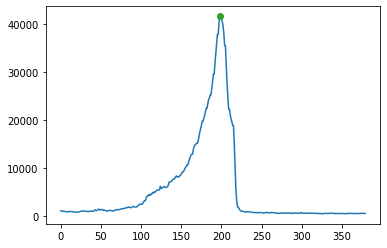

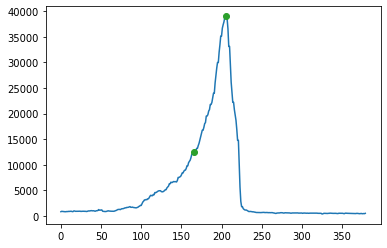

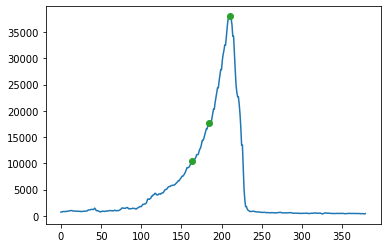

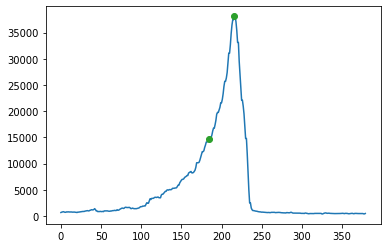

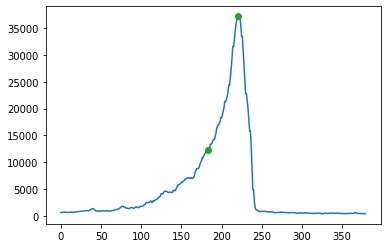

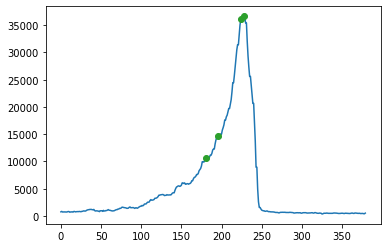

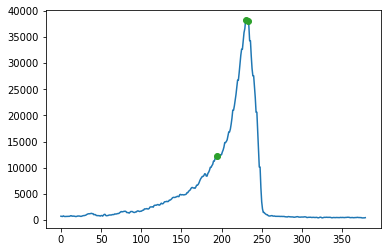

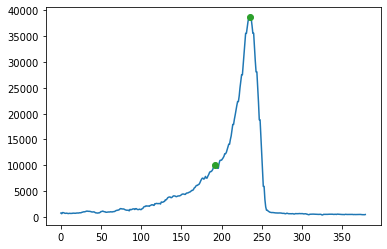

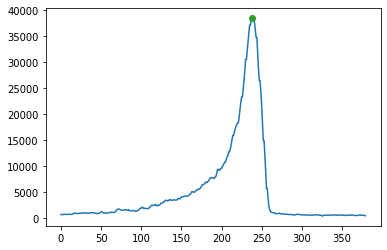

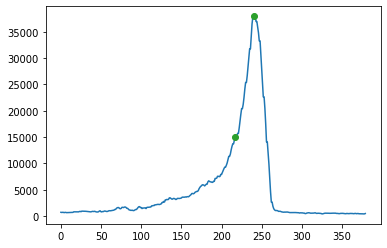

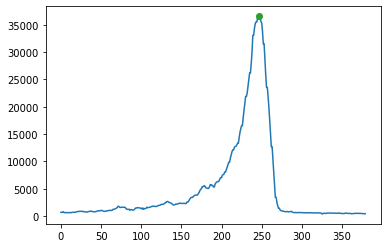

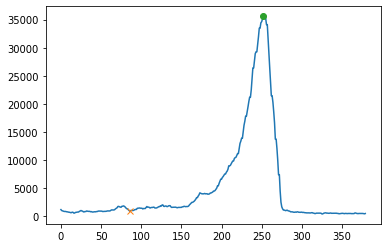

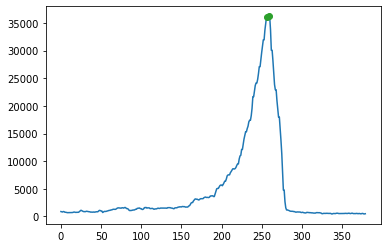

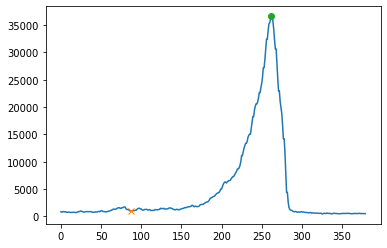

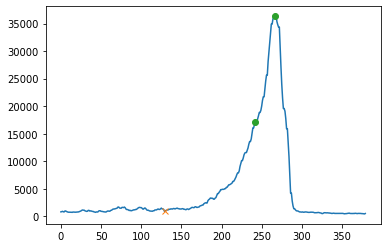

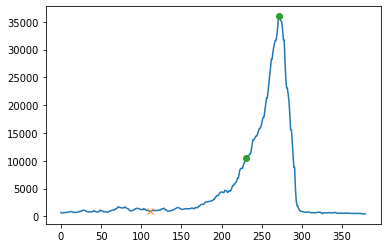

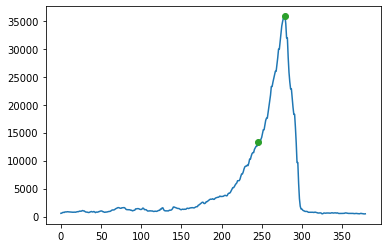

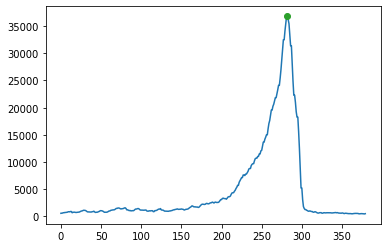

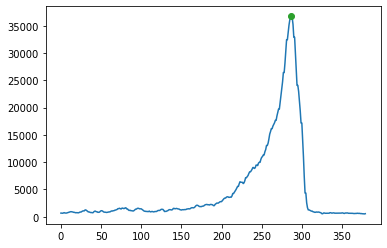

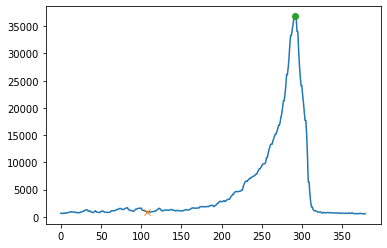

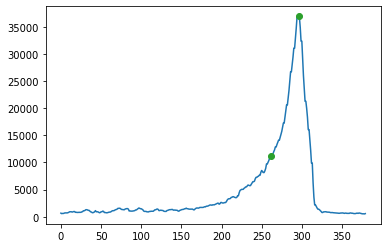

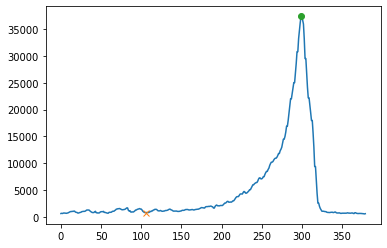

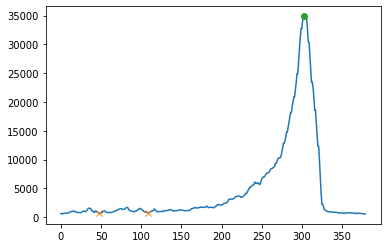

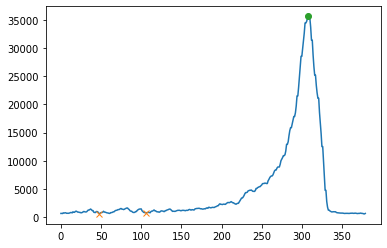

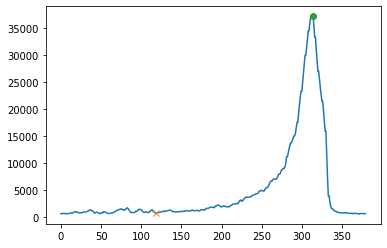

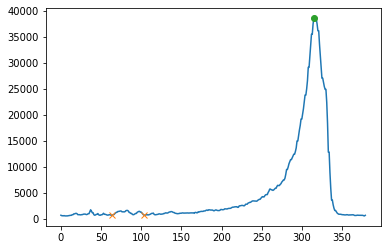

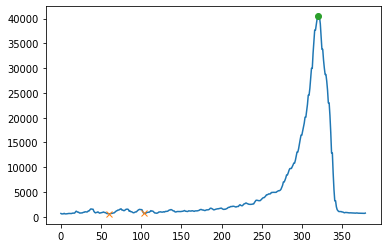

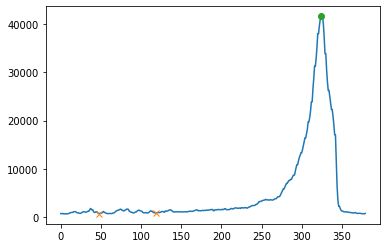

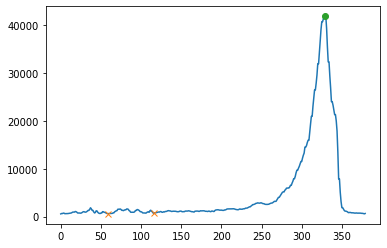

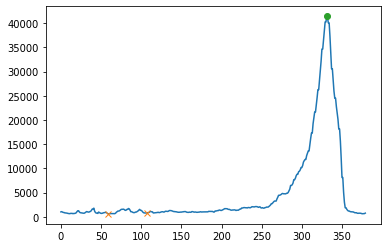

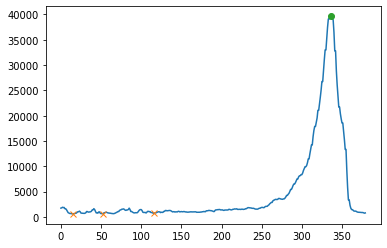

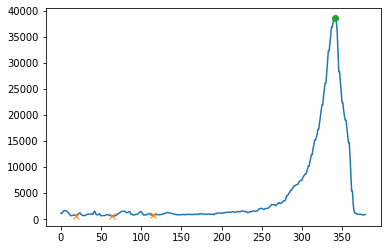

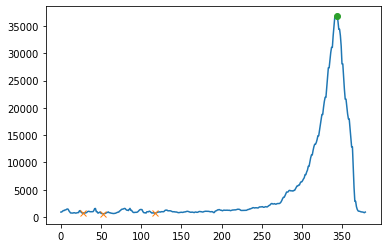

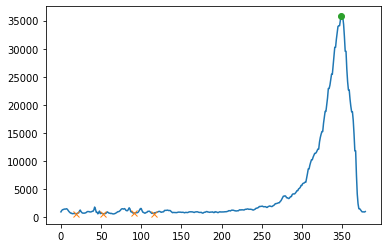

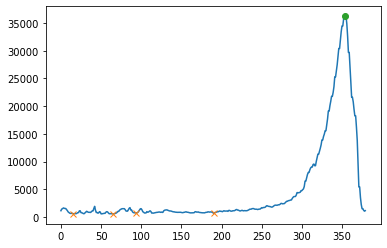

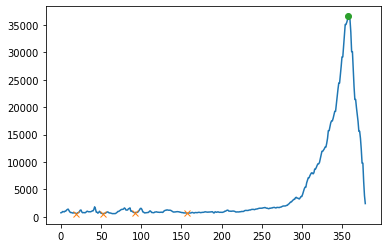

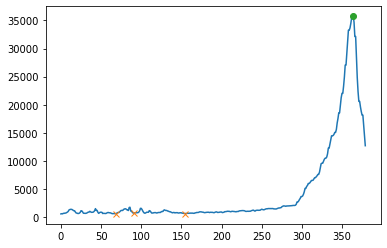

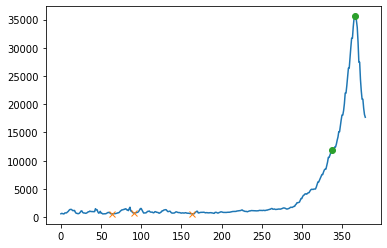

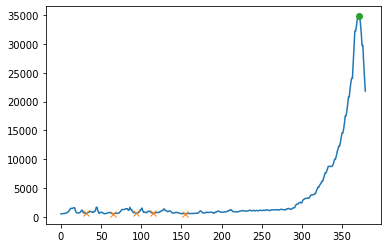

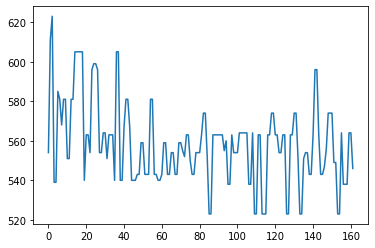

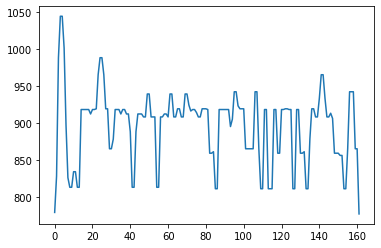

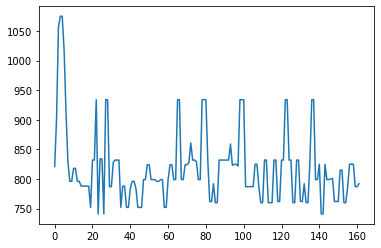

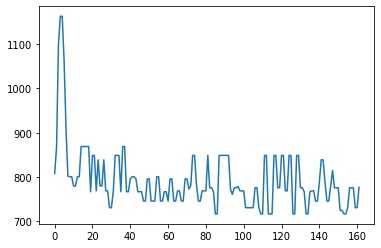

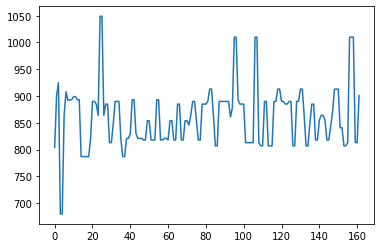

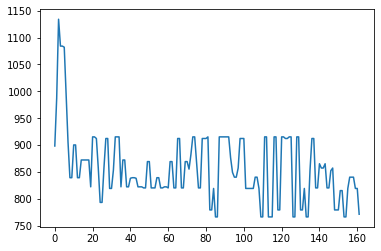

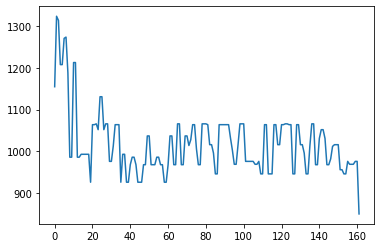

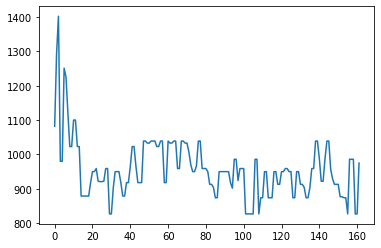

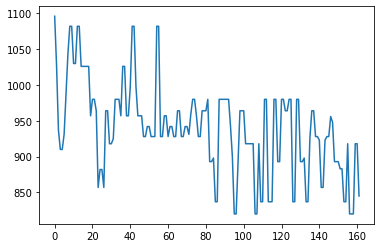

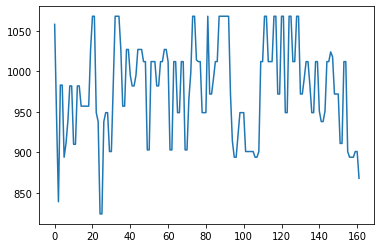

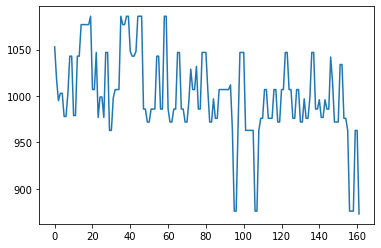

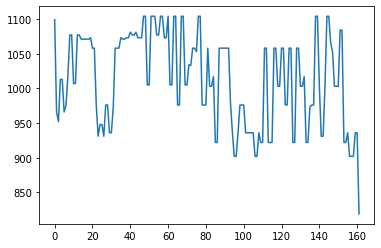

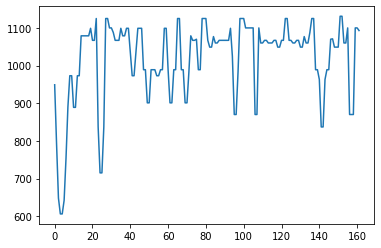

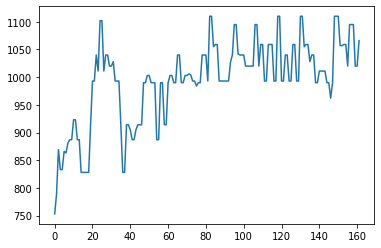

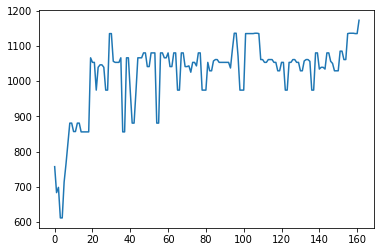

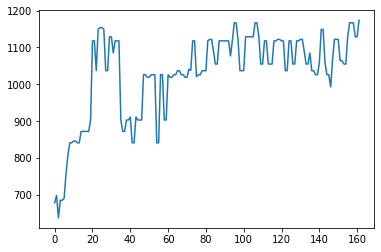

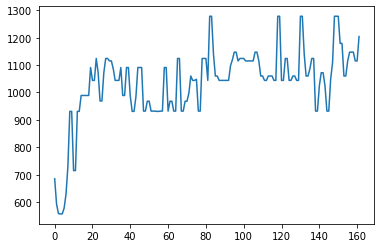

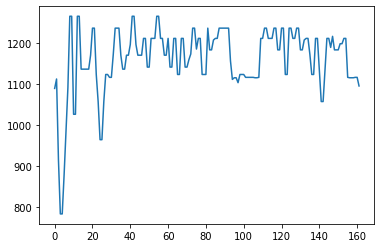

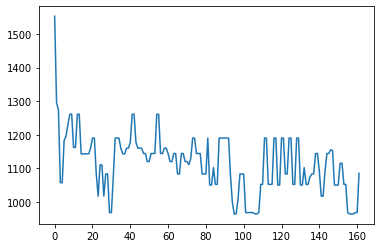

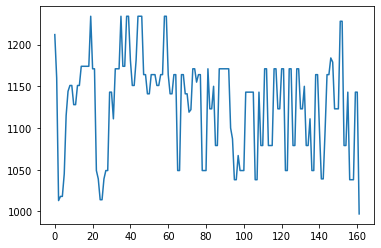

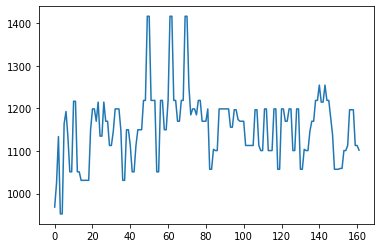

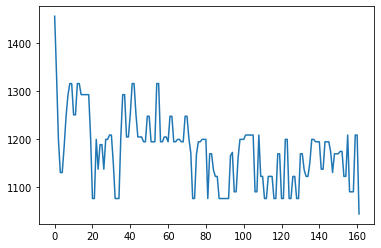

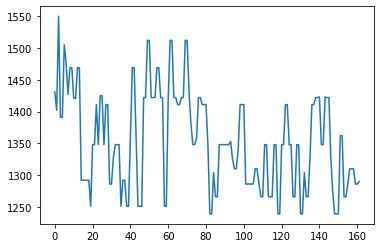

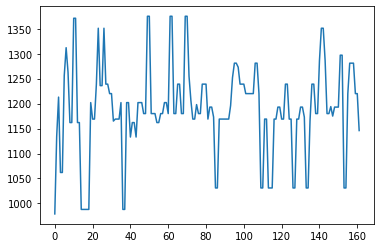

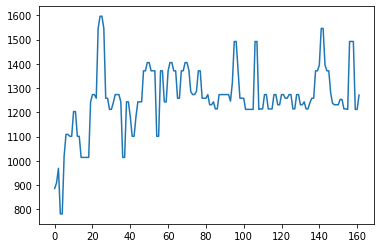

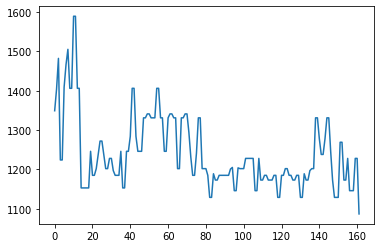

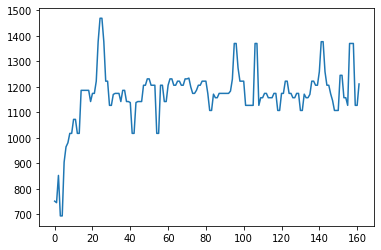

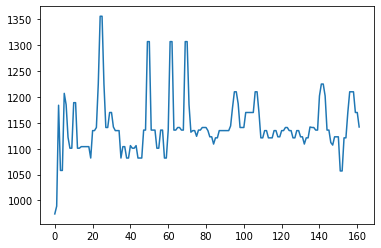

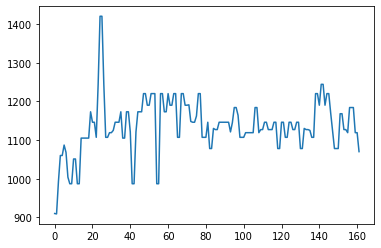

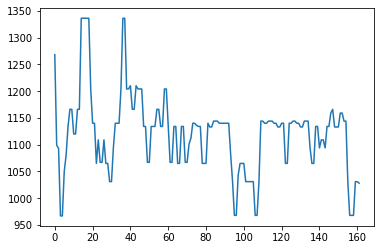

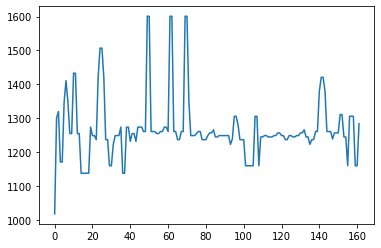

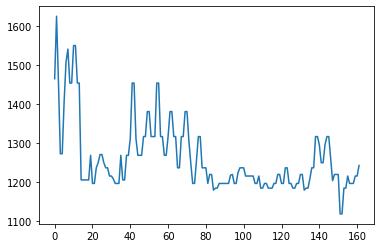

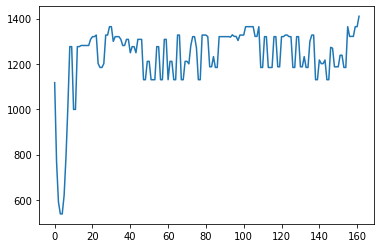

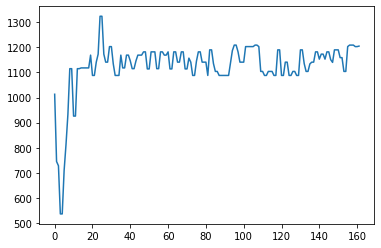

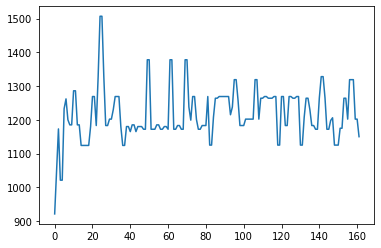

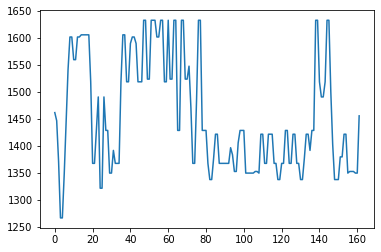

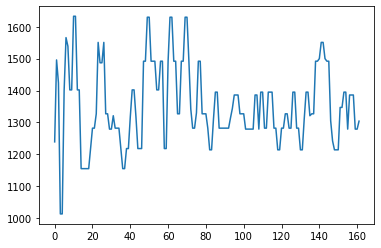

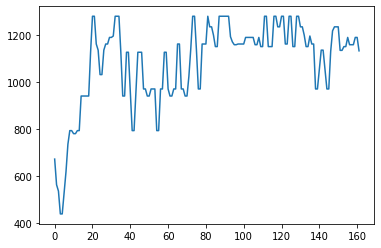

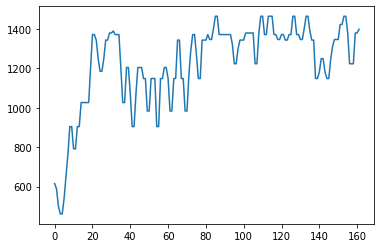

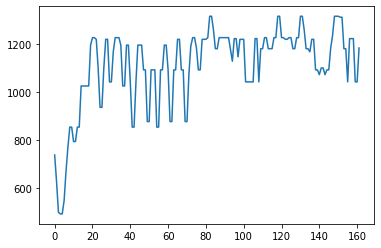

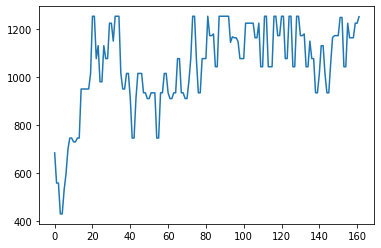

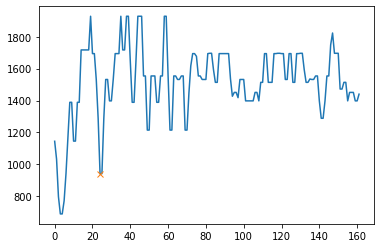

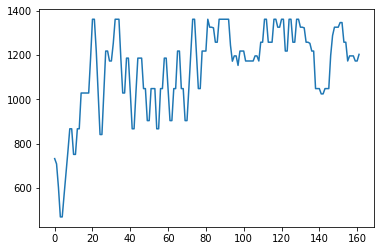

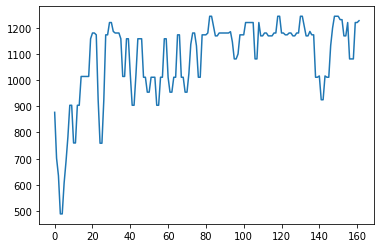

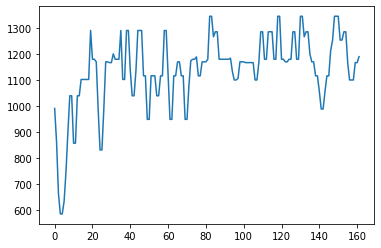

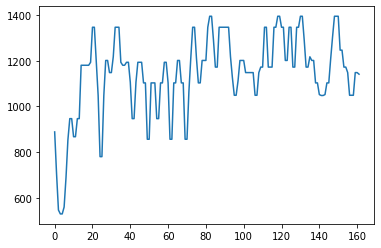

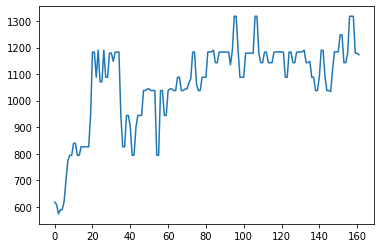

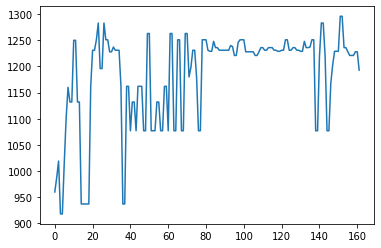

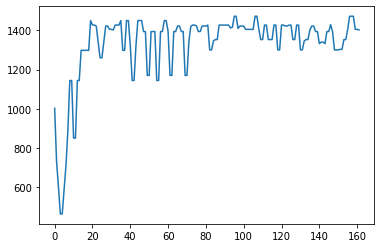

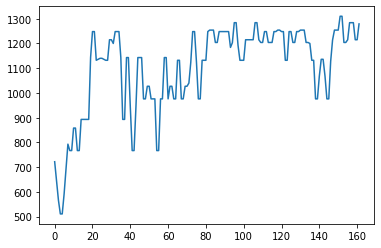

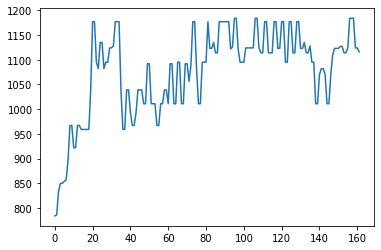

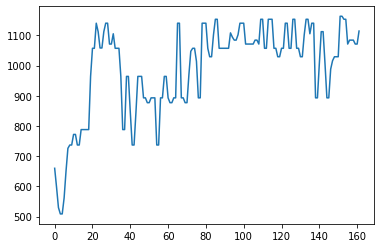

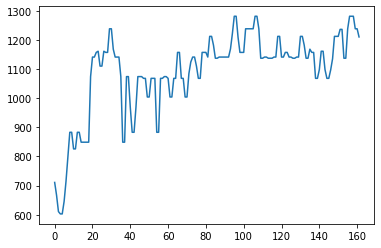

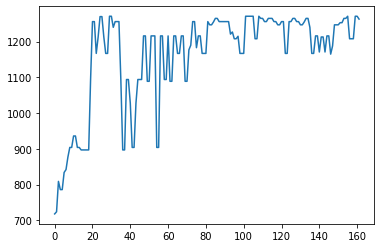

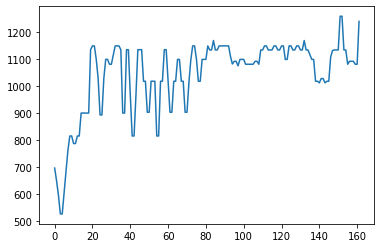

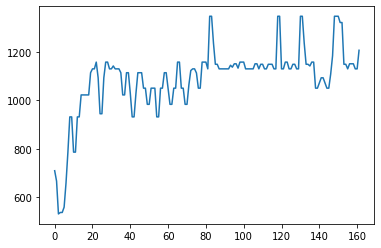

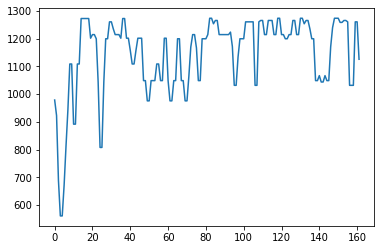

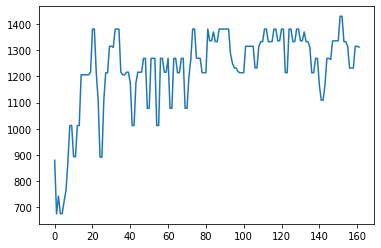

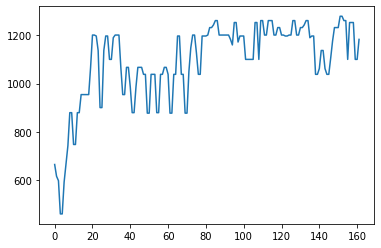

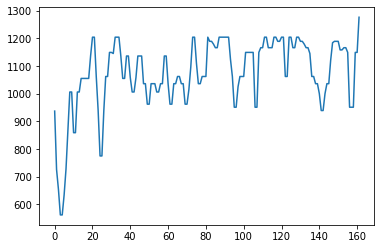

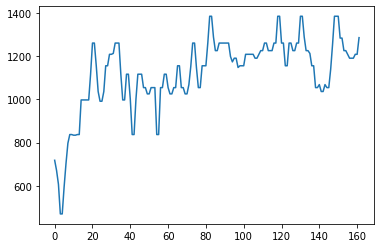

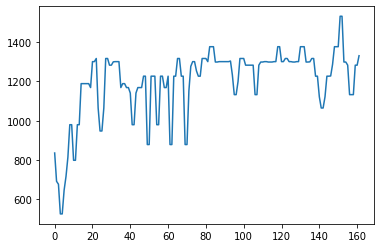

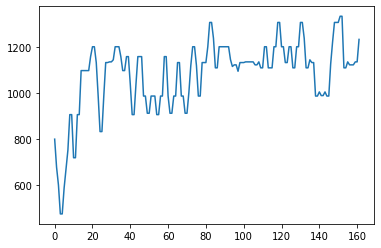

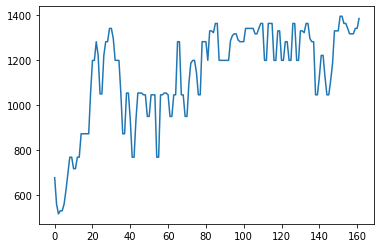

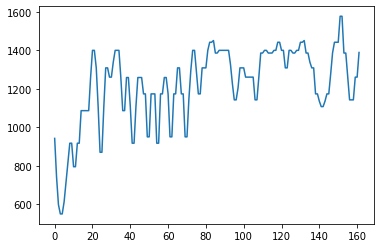

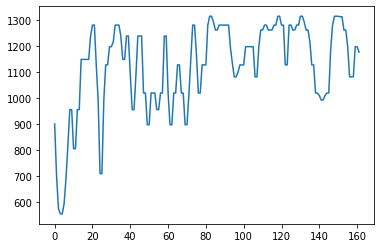

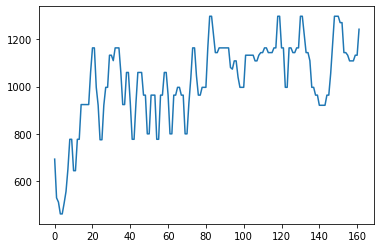

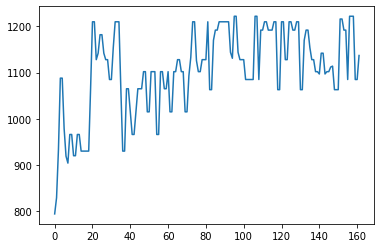

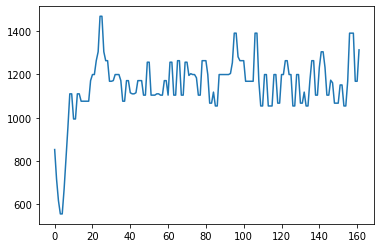

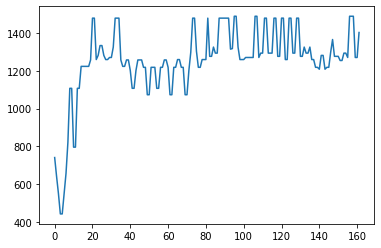

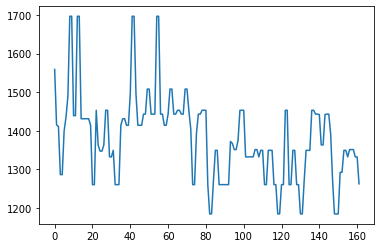

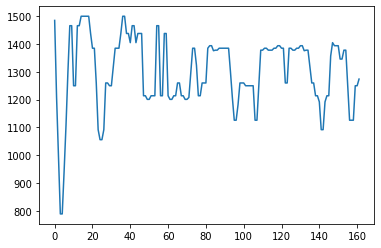

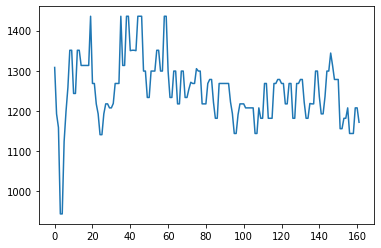

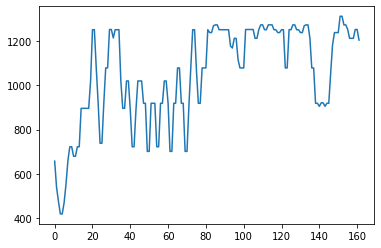

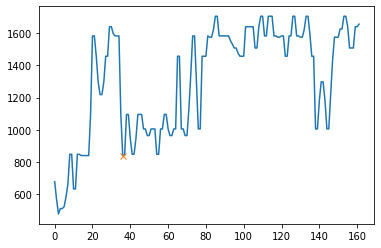

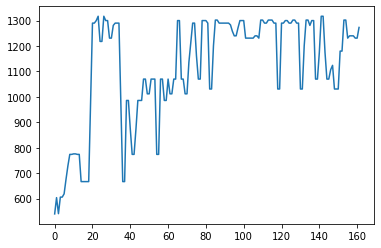

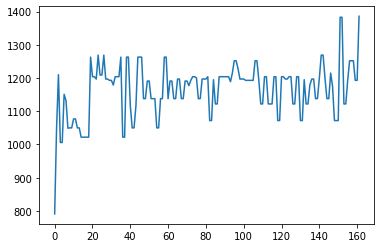

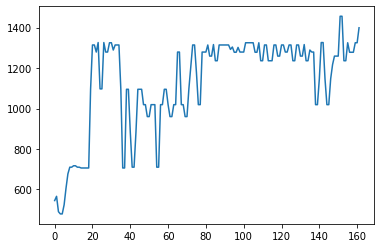

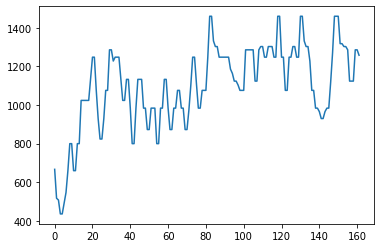

Finished!


In [4]:
with open('actin_stats.csv', 'w') as f:
    f.write('TrackID, timepoint, peakintensity, peak_peak_distance(um), center_peak_distance(um) \n')
    ## for each track write the intensity profile to file
    for trackid in unique_trackids:
        with open('actin_intensity_profile_' + str(trackid) + '.csv', 'w') as g:
            g.write('timepoint, track_position(um), intensity \n')
            track = sorted_positions[['Position X', 'Position Y', 'Time']] \
                                    [sorted_positions['TrackID'] == trackid]
            sorted_track = track.sort_values('Time').values
            ## for each timepoint in a track

            for k, im in enumerate(img):
                intensity = []
                dist = []
                ## for pairs of temporally adjacent bead positions
                for i in range(len(sorted_track) - 1):
                    ## bead pos in um
                    umbeadx, umbeady = sorted_track[i, 0], sorted_track[i, 1]
                    pixbeadx, pixbeady = int(sorted_track[i, 0]/pixsc), int(sorted_track[i, 1]/pixsc)
                  
                    pixbeadx_, pixbeady_ = int(sorted_track[i + 1, 0]/pixsc), int(sorted_track[i + 1, 1]/pixsc)
                    current_intensity = profile_line(im, (pixbeady, pixbeadx), (pixbeady_, pixbeadx_))
                    intensity.extend(current_intensity)
                    current_num_pix = len(current_intensity)
                    current_dist = np.linalg.norm(np.array((pixbeadx, pixbeady)) - np.array((pixbeadx_, pixbeady_)))
                  
                    if i == 0:
                        dist.extend(np.arange(current_num_pix)*current_dist)
                    else:
                        dist.extend(np.arange(current_num_pix)*current_dist + dist[-1])
                        
                track_distance = np.array(dist)*pixsc
                intensity = np.array(intensity)
                peaks, _ = find_peaks(intensity, height = 10000, prominence = 2)
                valley, _ = find_peaks(-intensity, prominence = 750, width = 3)

                if peaks.size > 1:
                    peak_dist = abs(peaks[-2] - peaks[-1])
                    if valley.size > 0:
                        center_dist = abs(valley[0] - peaks[-2])
                        if center_dist < 30:
                            f.write(str(trackid) + ',' + 
                                    str(k) + ',' + 
                                    str(intensity[peaks[-2]]) + ',' + 
                                    str(peak_dist*pixsc) + ',' +
                                    str(center_dist*pixsc) + '\n')

                for j, intval in enumerate(intensity):
                    g.write(str(k) + ',' + str(track_distance[j]*pixsc) + ',' + str(intval) + '\n')
                fig, ax = plt.subplots()
                ax.plot(intensity)
                ax.plot(valley, intensity[valley], 'x')
                ax.plot(peaks, intensity[peaks], 'o')
                plt.show()
print('Finished!')